## Optimization & Deep-Learning

尽管优化提供了一种最大限度地减少深度学习损失函数的方法，但本质上，优化和深度学习的目标是根本不同的。前者主要关注的是最小化目标，后者则关注在给定有限数据量的情况下寻找合适的模型。

例如，训练误差和泛化误差通常不同：由于优化算法的目标函数通常是基于训练数据集的损失函数，因此优化的目标是减少训练误差。但是，深度学习（或更广义地说，统计推断）的目标是减少泛化误差。为了实现后者，除了使用优化算法来减少训练误差之外，我们还需要注意过拟合。

In [1]:
import numpy as np
import torch
from mpl_toolkits import mplot3d
from d2l import torch as d2l

为了说明上述不同的目标，引入两个概念*风险*和*经验风险*。，经验风险是训练数据集的平均损失，而风险则是整个数据群的预期损失。下面我们定义了两个函数：风险函数`f`和经验风险函数`g`。假设我们只有有限的训练数据。因此，这里的`g`不如`f`平滑。


In [2]:
def f(x):
    return x * torch.cos(np.pi * x)

def g(x):
    return f(x) + 0.2 * torch.cos(5 * np.pi * x)

下图说明，训练数据集的最低经验风险可能与最低风险（泛化误差）不同。

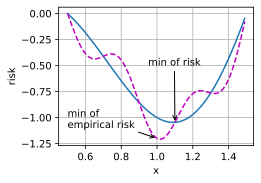

In [3]:
def annotate(text, xy, xytext):
    d2l.plt.gca().annotate(text, xy=xy, xytext=xytext,
                           arrowprops=dict(arrowstyle='->'))
    
x = torch.arange(0.5, 1.5, 0.01)
d2l.set_figsize((4.5, 2.5))
d2l.plot(x, [f(x), g(x)], 'x', 'risk')
annotate('min of\nempirical risk', (1.0, -1.2), (0.5, -1.1))
annotate('min of risk', (1.1, -1.05), (0.95, -0.5))

本章将关注优化算法在最小化目标函数方面的性能，而不是模型的泛化误差。在线性回归一章中，我们区分了优化问题中的解析解和数值解。在深度学习中，大多数目标函数都很复杂，没有解析解。相反，我们必须使用数值优化算法。本章中的优化算法都属于此类别。

深度学习优化存在许多挑战。其中最令人烦恼的是局部最小值、鞍点和梯度消失。

## Optimization Challenge

### Local Minimum

对于任何目标函数$f(x)$，如果在$x$处对应的$f(x)$值小于在$x$附近任意其他点的$f(x)$值，那么$f(x)$可能是局部最小值。如果$f(x)$在$x$处的值是整个域中目标函数的最小值，那么$f(x)$是全局最小值。

例如，给定函数

$$f(x) = x \cdot \text{cos}(\pi x) \text{ for } -1.0 \leq x \leq 2.0,$$

我们可以近似该函数的局部最小值和全局最小值。

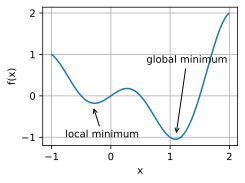

In [4]:
x = torch.arange(-1.0, 2.0, 0.01)
d2l.plot(x, [f(x)], 'x', 'f(x)')
annotate('local minimum', (-0.3, -0.25), (-0.77, -1.0))
annotate('global minimum', (1.1, -0.95), (0.6, 0.8))

### Saddle point

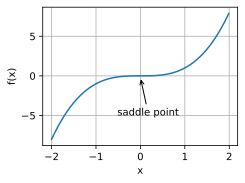

In [5]:
x = torch.arange(-2.0, 2.0, 0.01)
d2l.plot(x, [x**3], 'x', 'f(x)')
annotate('saddle point', (0, -0.2), (-0.52, -5.0))

如下例所示，较高维度的鞍点甚至更加隐蔽。考虑这个函数$f(x, y) = x^2 - y^2$。它的鞍点为$(0, 0)$。这是关于$y$的最大值，也是关于$x$的最小值。此外，它看起来像个马鞍，这就是鞍点的名字由来。


Text(0.5, 0.5, 'y')

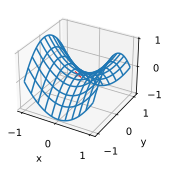

In [8]:
x, y = torch.meshgrid(torch.linspace(-1.0, 1.0, 101), torch.linspace(-1.0, 1.0, 101))
z = x**2 - y**2

ax = d2l.plt.figure().add_subplot(111, projection='3d')
ax.plot_wireframe(x, y, z, **{'rstride': 10, 'cstride': 10})
ax.plot([0], [0], [0], 'rx')  # 画点
ticks = [-1, 0, 1]  # 设置刻度值
d2l.plt.xticks(ticks)
d2l.plt.yticks(ticks)
ax.set_zticks(ticks)
d2l.plt.xlabel('x')
d2l.plt.ylabel('y')

我们假设函数的输入是$k$维向量，其输出是标量，因此其Hessian矩阵（也称黑塞矩阵）将有$k$个特征值。函数的解可能是局部最小值、局部最大值或函数梯度为零位置处的鞍点：

* 当函数在零梯度位置处的Hessian矩阵的特征值全部为正值时，我们有该函数的局部最小值；
* 当函数在零梯度位置处的Hessian矩阵的特征值全部为负值时，我们有该函数的局部最大值；
* 当函数在零梯度位置处的Hessian矩阵的特征值为负值和正值时，我们有该函数的一个鞍点。

对于高维度问题，至少*部分*特征值为负的可能性相当高。这使得鞍点比局部最小值更有可能出现。我们将在下一节介绍凸性时讨论这种情况的一些例外。简而言之，凸函数是Hessian函数的特征值永远不为负值的函数。不幸的是，大多数深度学习问题并不属于这一类。尽管如此，它还是研究优化算法的一个很好的工具。

### Gradient Vanishment

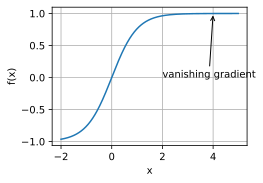

In [9]:
x = torch.arange(-2.0, 5.0, 0.01)
d2l.plot(x, [torch.tanh(x)], 'x', 'f(x)')
annotate('vanishing gradient', (4, 1), (2, 0.0))

[参考答案](https://zh.d2l.ai/chapter_optimization/optimization-intro.html#id8)

Q1
题目中的$d!$个等效方案翻译成等效解更好一点。

我们令输出层的输出为$Y_{out} = (w_1x + w_2x+…+w_d*x) + b$ 损失函数为$Loss(Y_{out}, Y_{true})$

题目中的解针对的是权重$W = (w_1,w_2,…,w_d)$,因为$w_i$是可变的,$x$是传入的参数不可变的

等效解即为让$Y_{out}$值不变的解,因此只要对$W$内部的元素$w_i$进行全排列即可,故有$A^d_d = d!$种解。

Q2

(1) 将$|M-\lambda|$行列式中每一行取负数，因为$|M-\lambda| = 0$,所以$|-M - (- \lambda)| = -1^n|M + \lambda| = 0$

故$-\lambda$也是特征值。所以$P(\lambda>0) = P(-\lambda>0) = P(\lambda<0)$。

(2) 因为还有$\lambda = 0$情况，即$Mx=0$ ,当$M$不可逆时有解。

Q3

合适的损失函数的选择问题，过拟合、泛化能力弱问题，梯度下降学习率选择问题

Q4

(1) 由于存在重力加速度，球下落的速度会逐渐变快

(2) 可以通过二阶导大小等来调节学习率

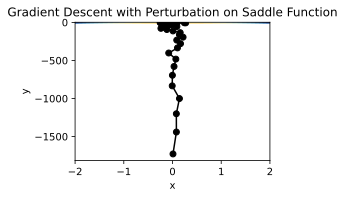

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def saddle_function(x, y):
    return x**2 - y**2

def gradient(x, y):
    df_dx = 2 * x
    df_dy = -2 * y
    return np.array([df_dx, df_dy])

def gradient_descent_with_perturbation(starting_point, learning_rate=0.1, perturbation_strength=0.1, iterations=50):
    path = []
    point = np.array(starting_point)
    
    for _ in range(iterations):
        path.append(point)
        grad = gradient(point[0], point[1])
        
        # Apply gradient descent step
        point = point - learning_rate * grad
        
        # Add random perturbation to escape saddle points
        perturbation = np.random.randn(2) * perturbation_strength
        point = point + perturbation
        
    return np.array(path)

# Initial point near the saddle point (0, 0)
starting_point = [0.1, 0.1]
path = gradient_descent_with_perturbation(starting_point)

# Plotting the saddle function and the optimization path
x = np.linspace(-2, 2, 400)
y = np.linspace(-2, 2, 400)
X, Y = np.meshgrid(x, y)
Z = saddle_function(X, Y)

plt.contour(X, Y, Z, levels=np.linspace(-4, 4, 30), cmap='RdYlBu')
plt.plot(path[:, 0], path[:, 1], marker='o', color='black')
plt.scatter([0], [0], color='red')  # Saddle point
plt.title("Gradient Descent with Perturbation on Saddle Function")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


## Convexity

In [1]:
import numpy as np
import torch
from mpl_toolkits import mplot3d
from d2l import torch as d2l

*凸集*（convex set）是凸性的基础。
简单地说，如果对于任何$a, b \in \mathcal{X}$，连接$a$和$b$的线段也位于$\mathcal{X}$中，则向量空间中的一个集合$\mathcal{X}$是*凸*（convex）的。
在数学术语上，这意味着对于所有$\lambda \in [0, 1]$，我们得到

$$\lambda  a + (1-\lambda)  b \in \mathcal{X} \text{ 当 } a, b \in \mathcal{X}.$$

下图中第一组存在不包含在集合内部的线段，所以该集合是非凸的，而另外两组则没有这样的问题。

![第一组是非凸的，另外两组是凸的。](./img/pacman.svg)

接下来来看一下交集。
假设$\mathcal{X}$和$\mathcal{Y}$是凸集，那么$\mathcal {X} \cap \mathcal{Y}$也是凸集的。
现在考虑任意$a, b \in \mathcal{X} \cap \mathcal{Y}$，
因为$\mathcal{X}$和$\mathcal{Y}$是凸集，
所以连接$a$和$b$的线段包含在$\mathcal{X}$和$\mathcal{Y}$中。
鉴于此，它们也需要包含在$\mathcal {X} \cap \mathcal{Y}$中，从而证明我们的定理。

![两个凸集的交集是凸的。](./img/convex-intersect.svg)

然而对于并集而言，我们并没有这么好的结论，取两个不相交的凸集可证明。

现在我们有了凸集，我们可以引入*凸函数*（convex function）$f$。
给定一个凸集$\mathcal{X}$，如果对于所有$x, x' \in \mathcal{X}$和所有$\lambda \in [0, 1]$，函数$f: \mathcal{X} \to \mathbb{R}$是凸的，我们可以得到

$$\lambda f(x) + (1-\lambda) f(x') \geq f(\lambda x + (1-\lambda) x').$$

为了说明这一点，让我们绘制一些函数并检查哪些函数满足要求。
下面我们定义一些函数，包括凸函数和非凸函数。

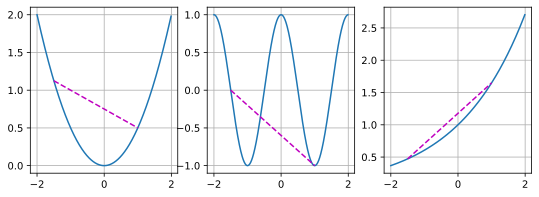

In [2]:
f = lambda x: 0.5 * x**2  # 凸函数
g = lambda x: torch.cos(np.pi * x)  # 非凸函数 
h = lambda x: torch.exp(0.5 * x)  # 凸函数

x, segment = torch.arange(-2, 2, 0.01), torch.tensor([-1.5, 1])
d2l.use_svg_display()
_, axes = d2l.plt.subplots(1, 3, figsize=(9, 3))
for ax, func in zip(axes, [f, g, h]):
    d2l.plot([x, segment], [func(x), func(segment)], axes=ax)

给定一个凸函数$f$，最有用的数学工具之一就是*詹森不等式*（Jensen's inequality）。
它是凸性定义的一种推广：

$$\sum_i \alpha_i f(x_i)  \geq f\left(\sum_i \alpha_i x_i\right) \text{ and } E_X[f(X)] \geq f\left(E_X[X]\right),$$

其中$\alpha_i$是满足$\sum_i \alpha_i = 1$的非负实数，$X$是随机变量。
换句话说，凸函数的期望不小于期望的凸函数，其中后者通常是一个更简单的表达式。
为了证明第一个不等式，我们多次将凸性的定义应用于一次求和中的一项。

詹森不等式的一个常见应用：用一个较简单的表达式约束一个较复杂的表达式。
例如，它可以应用于部分观察到的随机变量的对数似然。
具体地说，由于$\int P(Y) P(X \mid Y) dY = P(X)$，所以

$$E_{Y \sim P(Y)}[-\log P(X \mid Y)] \geq -\log P(X),$$

这里，$Y$是典型的未观察到的随机变量，$P(Y)$是它可能如何分布的最佳猜测，$P(X)$是将$Y$积分后的分布。
例如，在聚类中$Y$可能是簇标签，而在应用簇标签时，$P(X \mid Y)$是生成模型。


### Property

#### 1.

首先凸函数的局部极小值也是全局极小值。
下面我们用反证法给出证明。

假设$x^{\ast} \in \mathcal{X}$是一个局部最小值，则存在一个很小的正值$p$，使得当$x \in \mathcal{X}$满足$0 < |x - x^{\ast}| \leq p$时，有$f(x^{\ast}) < f(x)$。

现在假设局部极小值$x^{\ast}$不是$f$的全局极小值：存在$x' \in \mathcal{X}$使得$f(x') < f(x^{\ast})$。
则存在
$\lambda \in [0, 1)$，比如$\lambda = 1 - \frac{p}{|x^{\ast} - x'|}$，使得
$0 < |\lambda x^{\ast} + (1-\lambda) x' - x^{\ast}| \leq p$。

然而，根据凸性的性质，有

$$\begin{aligned}
    f(\lambda x^{\ast} + (1-\lambda) x') &\leq \lambda f(x^{\ast}) + (1-\lambda) f(x') \\
    &< \lambda f(x^{\ast}) + (1-\lambda) f(x^{\ast}) \\
    &= f(x^{\ast}), \\
\end{aligned}$$

这与$x^{\ast}$是局部最小值相矛盾。
因此，不存在$x' \in \mathcal{X}$满足$f(x') < f(x^{\ast})$。
综上所述，局部最小值$x^{\ast}$也是全局最小值。

但是请注意，这并不意味着不能有多个全局最小值，或者可能不存在一个全局最小值。
例如，函数$f(x) = \mathrm{max}(|x|-1, 0)$在$[-1,1]$区间上都是最小值。
相反，函数$f(x) = \exp(x)$在$\mathbb{R}$上没有取得最小值。对于$x \to -\infty$，它趋近于$0$，但是没有$f(x) = 0$的$x$。

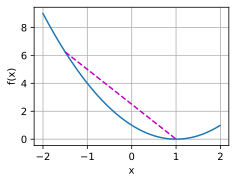

In [3]:
f = lambda x: (x - 1) ** 2
d2l.set_figsize()
d2l.plot([x, segment], [f(x), f(segment)], 'x', 'f(x)')

#### 2.

我们可以方便地通过凸函数的*下水平集*（below sets）定义凸集。
具体来说，给定一个定义在凸集$\mathcal{X}$上的凸函数$f$，其任意一个下水平集

$$\mathcal{S}_b := \{x | x \in \mathcal{X} \text{ and } f(x) \leq b\}$$

是凸的。

让我们快速证明一下。
对于任何$x, x' \in \mathcal{S}_b$，我们需要证明：当$\lambda \in [0, 1]$时，$\lambda x + (1-\lambda) x' \in \mathcal{S}_b$。
因为$f(x) \leq b$且$f(x') \leq b$，所以

$$f(\lambda x + (1-\lambda) x') \leq \lambda f(x) + (1-\lambda) f(x') \leq b.$$


#### 3. Convexity & Second Derivative

[矩阵求导回顾](https://sanbuphy.github.io/p/%E7%9F%A9%E9%98%B5%E6%B1%82%E5%AF%BC%E7%AE%80%E6%98%93%E5%85%A5%E9%97%A8%E6%89%8B%E5%86%8C/)

当一个函数的二阶导数$f: \mathbb{R}^n \rightarrow \mathbb{R}$存在时，我们很容易检查这个函数的凸性。
我们需要做的就是检查$\nabla^2f \succeq 0$，
即对于所有$\mathbf{x} \in \mathbb{R}^n$，$\mathbf{x}^\top \mathbf{H} \mathbf{x} \geq 0$.
例如，函数$f(\mathbf{x}) = \frac{1}{2} \|\mathbf{x}\|^2$是凸的，因为$\nabla^2 f = \mathbf{1}$，即其导数是单位矩阵。

更正式地讲，$f$为凸函数，当且仅当任意二次可微一维函数$f: \mathbb{R}^n \rightarrow \mathbb{R}$是凸的。
对于任意二次可微多维函数$f: \mathbb{R}^{n} \rightarrow \mathbb{R}$，
它是凸的当且仅当它的Hessian $\nabla^2f\succeq 0$。

综上，一个二次可微函数是凸函数，当且仅当其Hessian（二阶导数矩阵）是半正定的。

我们可以证明多维情况：
多维函数$f:\mathbb{R}^n\rightarrow\mathbb{R}$是凸函数，当且仅当$g(z) \stackrel{\mathrm{def}}{=} f(z \mathbf{x} + (1-z)  \mathbf{y})$是凸的，这里$z \in [0,1]$，$\mathbf{x}, \mathbf{y} \in \mathbb{R}^n$。
根据一维情况，
此条成立的条件为，当且仅当对于所有$\mathbf{x}, \mathbf{y} \in \mathbb{R}^n$，
$g'' = (\mathbf{x} - \mathbf{y})^\top \mathbf{H}(\mathbf{x} - \mathbf{y}) \geq 0$（$\mathbf{H} \stackrel{\mathrm{def}}{=} \nabla^2f$）。
这相当于根据半正定矩阵的定义，$\mathbf{H} \succeq 0$。

#### 4. Lagrange Function

$$L(\mathbf{x}, \alpha_1, \ldots, \alpha_n) = f(\mathbf{x}) + \sum_{i=1}^n \alpha_i c_i(\mathbf{x}) \text{ where } \alpha_i \geq 0.$$

这里的变量$\alpha_i$（$i=1,\ldots,n$）是所谓的*拉格朗日乘数*（Lagrange multipliers），它确保约束被正确地执行。
选择它们的大小足以确保所有$i$的$c_i(\mathbf{x}) \leq 0$。
例如，对于$c_i(\mathbf{x}) < 0$中任意$\mathbf{x}$，我们最终会选择$\alpha_i = 0$。
此外，这是一个*鞍点*（saddlepoint）优化问题。
在这个问题中，我们想要使$L$相对于$\alpha_i$*最大化*（maximize），同时使它相对于$\mathbf{x}$*最小化*（minimize）。
有大量的文献解释如何得出函数$L(\mathbf{x}, \alpha_1, \ldots, \alpha_n)$。
我们这里只需要知道$L$的鞍点是原始约束优化问题的最优解就足够了。

一种至少近似地满足约束优化问题的方法是采用拉格朗日函数$L$。除了满足$c_i(\mathbf{x}) \leq 0$之外，我们只需将$\alpha_i c_i(\mathbf{x})$添加到目标函数$f(x)$。
这样可以确保不会严重违反约束。

事实上，我们一直在使用这个技巧。
比如权重衰减，在目标函数中加入$\frac{\lambda}{2} |\mathbf{w}|^2$，以确保$\mathbf{w}$不会增长太大。

满足约束条件的另一种策略是*投影*（projections）。
同样，我们之前也遇到过，例如在循环神经网络中处理梯度截断时，我们通过

$$\mathbf{g} \leftarrow \mathbf{g} \cdot \mathrm{min}(1, \theta/\|\mathbf{g}\|),$$

确保梯度的长度以$\theta$为界限。

这就是$\mathbf{g}$在半径为$\theta$的球上的*投影*（projection）。
更泛化地说，在凸集$\mathcal{X}$上的投影被定义为

$$\mathrm{Proj}_\mathcal{X}(\mathbf{x}) = \mathop{\mathrm{argmin}}_{\mathbf{x}' \in \mathcal{X}} \|\mathbf{x} - \mathbf{x}'\|.$$

它是$\mathcal{X}$中离$\mathbf{X}$最近的点。

[参考](https://www.cnblogs.com/CLGYPYJ/p/17605272.html)

## GD

In [1]:
import numpy as np
import torch
from d2l import torch as d2l

In [2]:
def f(x):
    return x ** 2

def f_grad(x):
    return 2 * x

In [3]:
def gd(eta, f_grad):
    x = 10.0
    results = [x]
    for i in range(10):
        x -= eta * f_grad(x)
        results.append(float(x))
    print(f'epoch 10, x: {x:f}')
    return results

results = gd(0.2, f_grad)

epoch 10, x: 0.060466


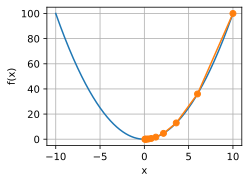

In [4]:
def show_trace(results, f):
    n = max(abs(min(results)), abs(max(results)))
    f_line = torch.arange(-n, n, 0.01)
    d2l.set_figsize()
    d2l.plot([f_line, results], [[f(x) for x in f_line], [f(x) for x in results]], 'x', 'f(x)', fmts=['-', '-o'])

show_trace(results, f)

### Learning Rate

epoch 10, x: 3.486784


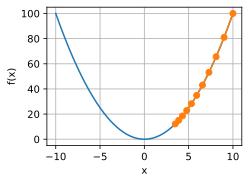

In [5]:
show_trace(gd(0.05, f_grad), f)

epoch 10, x: 61.917364


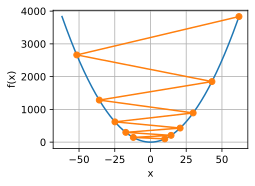

In [6]:
show_trace(gd(1.1, f_grad), f)

### Local Minimum

epoch 10, x: -1.528166


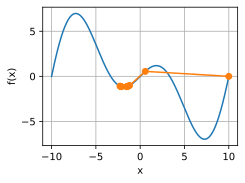

In [7]:
c = torch.tensor(0.15 * np.pi)

def f(x):
    return x * torch.cos(c * x)

def f_grad(x):
    return torch.cos(c * x) - c * x * torch.sin(c * x)

show_trace(gd(2, f_grad), f)

### Muti-variable GD

$$\nabla f(\mathbf{x}) = \bigg[\frac{\partial f(\mathbf{x})}{\partial x_1}, \frac{\partial f(\mathbf{x})}{\partial x_2}, \ldots, \frac{\partial f(\mathbf{x})}{\partial x_d}\bigg]^\top.$$

$$f(\mathbf{x} + \boldsymbol{\epsilon}) = f(\mathbf{x}) + \mathbf{\boldsymbol{\epsilon}}^\top \nabla f(\mathbf{x}) + \mathcal{O}(\|\boldsymbol{\epsilon}\|^2).$$

$$\mathbf{x} \leftarrow \mathbf{x} - \eta \nabla f(\mathbf{x}).$$

In [8]:
def train_2d(trainer, steps=20, f_grad=None):
    # s1和s2是稍后将使用的内部状态变量
    x1, x2, s1, s2 = -5, -2, 0, 0
    results = [(x1, x2)]
    for i in range(steps):
        if f_grad:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2, f_grad)
        else:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print(f'epoch {i + 1}, x1: {float(x1):f}, x2: {float(x2):f}')
    return results

In [9]:
def show_trace_2d(f, results):
    d2l.set_figsize()
    d2l.plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = torch.meshgrid(torch.arange(-5.5, 1.0, 0.1),
                            torch.arange(-3.0, 1.0, 0.1), indexing='ij')
    d2l.plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    d2l.plt.xlabel('x1')
    d2l.plt.ylabel('x2')

epoch 20, x1: -0.057646, x2: -0.000073


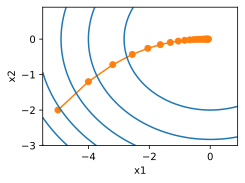

In [10]:
def f_2d(x1, x2):
    return x1 ** 2 + 2 * x2 ** 2

def f_2d_grad(x1, x2):
    return (2 * x1, 4 * x2)

def gd_2d(x1, x2, s1, s2, f_grad):
    g1, g2 = f_grad(x1, x2)
    return (x1 - eta * g1, x2 - eta * g2, 0, 0)

eta = 0.1
show_trace_2d(f_2d, train_2d(gd_2d, f_grad=f_2d_grad))

### Self Adaptation

#### Newton's method

回顾一些函数$f: \mathbb{R}^d \rightarrow \mathbb{R}$的泰勒展开式，事实上我们可以把它写成

$$f(\mathbf{x} + \boldsymbol{\epsilon}) = f(\mathbf{x}) + \boldsymbol{\epsilon}^\top \nabla f(\mathbf{x}) + \frac{1}{2} \boldsymbol{\epsilon}^\top \nabla^2 f(\mathbf{x}) \boldsymbol{\epsilon} + \mathcal{O}(\|\boldsymbol{\epsilon}\|^3).$$

为了避免繁琐的符号，我们将$\mathbf{H} \stackrel{\mathrm{def}}{=} \nabla^2 f(\mathbf{x})$定义为$f$的Hessian，是$d \times d$矩阵。

$f$的最小值满足$\nabla f = 0$。
通过取$\boldsymbol{\epsilon}$的导数，
再忽略不重要的高阶项，我们便得到

$$\nabla f(\mathbf{x}) + \mathbf{H} \boldsymbol{\epsilon} = 0 \text{ and hence }
\boldsymbol{\epsilon} = -\mathbf{H}^{-1} \nabla f(\mathbf{x}).$$

亦即：

$$x \rightarrow x - \eta * f'(x) / f''(x)$$

也就是说，作为优化问题的一部分，我们需要将Hessian矩阵$\mathbf{H}$求逆。

举一个简单的例子，对于$f(x) = \frac{1}{2} x^2$，我们有$\nabla f(x) = x$和$\mathbf{H} = 1$。
因此，对于任何$x$，我们可以获得$\epsilon = -x$。
换言之，单单一步就足以完美地收敛，而无须任何调整。
我们在这里比较幸运：泰勒展开式是确切的，因为$f(x+\epsilon)= \frac{1}{2} x^2 + \epsilon x + \frac{1}{2} \epsilon^2$。

让我们看看其他问题。
给定一个凸双曲余弦函数$c$，其中$c$为某些常数，
我们可以看到经过几次迭代后，得到了$x=0$处的全局最小值。

epoch 10, x: tensor(0.)


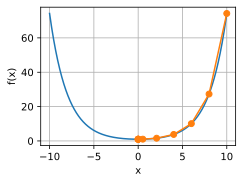

In [11]:
c = torch.tensor(0.5)

def f(x):
    return torch.cosh(c * x)

def f_grad(x):
    return c * torch.sinh(c * x)

def f_hess(x):  # 目标函数的Hessian
    return c**2 * torch.cosh(c * x)

def newton(eta=1):
    x = 10.0
    results = [x]
    for _ in range(10):
        x -= eta * f_grad(x) / f_hess(x)
        results.append(float(x))
    print('epoch 10, x:', x)
    return results

show_trace(newton(), f)

现在让我们考虑一个非凸函数，比如$f(x) = x \cos(c x)$，$c$为某些常数。
请注意在牛顿法中，我们最终将除以Hessian。
这意味着如果二阶导数是负的，$f$的值可能会趋于增加。
这是这个算法的致命缺陷！
让我们看看实践中会发生什么。


epoch 10, x: tensor(26.8341)


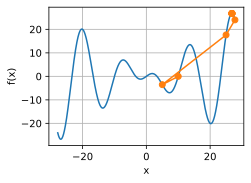

In [13]:
c = torch.tensor(0.15 * np.pi)

def f(x):
    return x * torch.cos(c * x)

def f_grad(x):
    return torch.cos(c * x) - c * x * torch.sin(c * x)

def f_hess(x):
    return - x * c**2 * torch.cos(c * x) - 2 * c * torch.sin(c * x)

show_trace(newton(), f)

这发生了惊人的错误。我们怎样才能修正它？
一种方法是用取Hessian的绝对值来修正，另一个策略是重新引入学习率。
这似乎违背了初衷，但不完全是——拥有二阶信息可以使我们在曲率较大时保持谨慎，而在目标函数较平坦时则采用较大的学习率。
让我们看看在学习率稍小的情况下它是如何生效的，比如$\eta = 0.5$。
如我们所见，我们有了一个相当高效的算法。


epoch 10, x: tensor(7.2699)


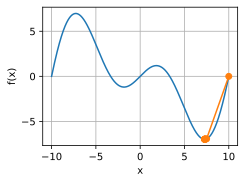

In [14]:
show_trace(newton(0.5), f)

#### Analysis of Convergence

在此，我们以部分目标凸函数$f$为例，分析它们的牛顿法收敛速度。
这些目标凸函数三次可微，而且二阶导数不为零，即$f'' > 0$。
由于多变量情况下的证明是对以下一维参数情况证明的直接拓展，对我们理解这个问题不能提供更多帮助，因此我们省略了多变量情况的证明。

用$x^{(k)}$表示$x$在第$k^\mathrm{th}$次迭代时的值，
令$e^{(k)} \stackrel{\mathrm{def}}{=} x^{(k)} - x^*$表示$k^\mathrm{th}$迭代时与最优性的距离。
通过泰勒展开，我们得到条件$f'(x^*) = 0$可以写成

$$0 = f'(x^{(k)} - e^{(k)}) = f'(x^{(k)}) - e^{(k)} f''(x^{(k)}) + \frac{1}{2} (e^{(k)})^2 f'''(\xi^{(k)}),$$

这对某些$\xi^{(k)} \in [x^{(k)} - e^{(k)}, x^{(k)}]$成立。
将上述展开除以$f''(x^{(k)})$得到

$$e^{(k)} - \frac{f'(x^{(k)})}{f''(x^{(k)})} = \frac{1}{2} (e^{(k)})^2 \frac{f'''(\xi^{(k)})}{f''(x^{(k)})}.$$

回想之前的方程$x^{(k+1)} = x^{(k)} - f'(x^{(k)}) / f''(x^{(k)})$。
代入这个更新方程，取两边的绝对值，我们得到

$$\left|e^{(k+1)}\right| = \frac{1}{2}(e^{(k)})^2 \frac{\left|f'''(\xi^{(k)})\right|}{f''(x^{(k)})}.$$

因此，每当我们处于有界区域$\left|f'''(\xi^{(k)})\right| / (2f''(x^{(k)})) \leq c$，
我们就有一个二次递减误差

$$\left|e^{(k+1)}\right| \leq c (e^{(k)})^2.$$

另一方面，优化研究人员称之为“线性”收敛，而将$\left|e^{(k+1)}\right| \leq \alpha \left|e^{(k)}\right|$这样的条件称为“恒定”收敛速度。
请注意，我们无法估计整体收敛的速度，但是一旦我们接近极小值，收敛将变得非常快。
另外，这种分析要求$f$在高阶导数上表现良好，即确保$f$在如何变化它的值方面没有任何“超常”的特性。

### Preprocess

计算和存储完整的Hessian非常昂贵，而改善这个问题的一种方法是“预处理”。
它回避了计算整个Hessian，而只计算“对角线”项，即如下的算法更新：

$$\mathbf{x} \leftarrow \mathbf{x} - \eta \mathrm{diag}(\mathbf{H})^{-1} \nabla f(\mathbf{x}).$$

### Work

In [25]:
def show_trace_2d(f, results):
    d2l.set_figsize()
    d2l.plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = torch.meshgrid(torch.arange(-5.0, -4.0, 0.1),
                            torch.arange(-3.0, -1.0, 0.1), indexing='ij')
    d2l.plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    d2l.plt.xlabel('x1')
    d2l.plt.ylabel('x2')

epoch 20, x1: -5.416478, x2: -2.253825


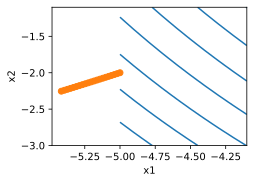

In [27]:
def f_2d(x1, x2):
    return torch.log(x1 + 10) + torch.log(x2 + 10)

def f_2d_grad(x1, x2):
    return (1 / (x1 + 10), 1 / (x2 + 10))

def gd_2d(x1, x2, s1, s2, f_grad):
    g1, g2 = f_grad(x1, x2)
    return (x1 - eta * g1, x2 - eta * g2, 0, 0)

eta = 0.1
show_trace_2d(f_2d, train_2d(gd_2d, f_grad=f_2d_grad))

epoch 10, x: tensor(20.2219)


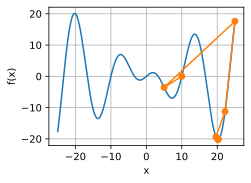

In [28]:
c = torch.tensor(0.15 * np.pi)

def f(x):
    return x * torch.cos(c * x)

def f_grad(x):
    return torch.cos(c * x) - c * x * torch.sin(c * x)

def f_hess(x):  # Hessian预处理-绝对值版
    return abs(- x * c**2 * torch.cos(c * x) - 2 * c * torch.sin(c * x))

show_trace(newton(), f)

[参考](https://www.cnblogs.com/CLGYPYJ/p/17605272.html)

## SGD

In [1]:
import math
import torch
from d2l import torch as d2l

在深度学习中，目标函数通常是训练数据集中每个样本的损失函数的平均值。给定$n$个样本的训练数据集，我们假设$f_i(\mathbf{x})$是关于索引$i$的训练样本的损失函数，其中$\mathbf{x}$是参数向量。然后我们得到目标函数

$$f(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n f_i(\mathbf{x}).$$

$\mathbf{x}$的目标函数的梯度计算为

$$\nabla f(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\mathbf{x}).$$

随机梯度下降（SGD）可降低每次迭代时的计算代价。在随机梯度下降的每次迭代中，我们对数据样本随机均匀采样一个索引$i$，其中$i\in\{1,\ldots, n\}$，并计算梯度$\nabla f_i(\mathbf{x})$以更新$\mathbf{x}$：

$$\mathbf{x} \leftarrow \mathbf{x} - \eta \nabla f_i(\mathbf{x}),$$

其中$\eta$是学习率。我们可以看到，计算代价从梯度下降的$\mathcal{O}(n)$降至常数$\mathcal{O}(1)$。此外，我们要强调，随机梯度$\nabla f_i(\mathbf{x})$是对完整梯度$\nabla f(\mathbf{x})$的无偏估计，因为

$$\mathbb{E}_i \nabla f_i(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\mathbf{x}) = \nabla f(\mathbf{x}).$$

这意味着，平均而言，随机梯度是对梯度的良好估计。

现在，我们将把它与梯度下降进行比较，方法是向梯度添加均值为0、方差为1的随机噪声，以模拟随机梯度下降。

In [2]:
def f(x1, x2):
    return x1 ** 2 +  2 * x2 ** 2

def f_grad(x1, x2):
    return (2 * x1, 4 * x2)

In [3]:
def sgd(x1, x2, s1, s2, f_grad):
    g1, g2 = f_grad(x1, x2)
    # 模拟有噪声的梯度
    g1 += torch.normal(0.0, 1, (1,)).item()
    g2 += torch.normal(0.0, 1, (1,)).item()
    eta_t = eta * lr()
    return (x1 - eta_t * g1, x2 - eta_t * g2, 0, 0)

epoch 50, x1: -0.110609, x2: 0.107099


c:\Users\Jason Chen\.conda\envs\d2l\lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


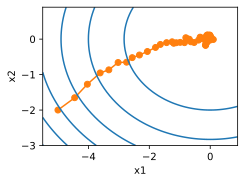

In [4]:
def constant_lr():
    return 0.5

eta = 0.1
lr = constant_lr
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=50, f_grad=f_grad))

正如我们所看到的，随机梯度下降中变量的轨迹比我们在`GD`中观察到的梯度下降中观察到的轨迹嘈杂得多。这是由于梯度的随机性质。也就是说，即使我们接近最小值，我们仍然受到通过$\eta \nabla f_i(\mathbf{x})$的瞬间梯度所注入的不确定性的影响。这给我们留下了唯一的选择：改变学习率$\eta$。但是，如果我们选择的学习率太小，我们一开始就不会取得任何有意义的进展。另一方面，如果我们选择的学习率太大，我们将无法获得一个好的解决方案，如上所示。解决这些相互冲突的目标的唯一方法是在优化过程中***动态***降低学习率。

### Dynamic Learning Rate

以下是随着时间推移调整$\eta$时使用的一些基本策略（稍后我们将讨论更高级的策略）：

$$
\begin{aligned}
    \eta(t) & = \eta_i \text{ if } t_i \leq t \leq t_{i+1}  && \text{分段常数} \\
    \eta(t) & = \eta_0 \cdot e^{-\lambda t} && \text{指数衰减} \\
    \eta(t) & = \eta_0 \cdot (\beta t + 1)^{-\alpha} && \text{多项式衰减}
\end{aligned}
$$

在第一个*分段常数*（piecewise constant）场景中，我们会降低学习率，例如，每当优化进度停顿时。这是训练深度网络的常见策略。或者，我们可以通过*指数衰减*（exponential decay）来更积极地减低它。不幸的是，这往往会导致算法收敛之前过早停止。一个受欢迎的选择是$\alpha = 0.5$的*多项式衰减*（polynomial decay）。在凸优化的情况下，有许多证据表明这种速率表现良好。

epoch 1000, x1: -0.833520, x2: -0.085976


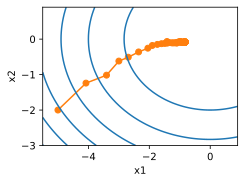

In [5]:
def exponential_lr():
    # 在函数外部定义，而在内部更新的全局变量
    global t
    t += 1
    return math.exp(-0.1 * t)

t = 1
lr = exponential_lr
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps = 1000, f_grad=f_grad))

epoch 50, x1: -0.007821, x2: -0.066899


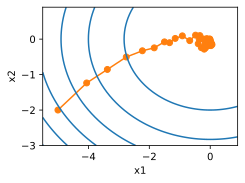

In [6]:
def polynomial_lr():
    global t
    t += 1
    return (1 + 0.1 * t) ** (-0.5)

t = 1
lr = polynomial_lr
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=50, f_grad=f_grad))

## Minibatch SGD

### Vectorize & Cache

使用小批量的决策的核心是计算效率。
当考虑与多个GPU和多台服务器并行处理时，这一点最容易被理解。在这种情况下，我们需要向每个GPU发送至少一张图像。
有了每台服务器8个GPU和16台服务器，我们就能得到大小为128的小批量。

当涉及到单个GPU甚至CPU时，事情会更微妙一些：
这些设备有多种类型的内存、通常情况下多种类型的计算单元以及在它们之间不同的带宽限制。
例如，一个CPU有少量寄存器（register），L1和L2缓存，以及L3缓存（在不同的处理器内核之间共享）。
随着缓存的大小的增加，它们的延迟也在增加，同时带宽在减少。
可以说，处理器能够执行的操作远比主内存接口所能提供的多得多。

因此我们使用足够快的CPU缓存层次结构来为处理器提供数据。
这是深度学习中批量处理背后的推动力。
举一个简单的例子：矩阵-矩阵乘法。
比如$\mathbf{A} = \mathbf{B}\mathbf{C}$，我们有很多方法来计算$\mathbf{A}$。例如，我们可以尝试以下方法：

1. 我们可以计算$\mathbf{A}_{ij} = \mathbf{B}_{i,:} \mathbf{C}_{:,j}^\top$，也就是说，我们可以通过点积进行逐元素计算。
1. 我们可以计算$\mathbf{A}_{:,j} = \mathbf{B} \mathbf{C}_{:,j}^\top$，也就是说，我们可以一次计算一列。同样，我们可以一次计算$\mathbf{A}$一行$\mathbf{A}_{i,:}$。
1. 我们可以简单地计算$\mathbf{A} = \mathbf{B} \mathbf{C}$。
1. 我们可以将$\mathbf{B}$和$\mathbf{C}$分成较小的区块矩阵，然后一次计算$\mathbf{A}$的一个区块。

如果我们使用第一个选择，每次我们计算一个元素$\mathbf{A}_{ij}$时，都需要将一行和一列向量复制到CPU中。
更糟糕的是，由于矩阵元素是按顺序对齐的，因此当从内存中读取它们时，我们需要访问两个向量中许多不相交的位置。
第二种选择相对更有利：我们能够在遍历$\mathbf{B}$的同时，将列向量$\mathbf{C}_{:,j}$保留在CPU缓存中。
它将内存带宽需求减半，相应地提高了访问速度。
第三种选择表面上是最可取的，然而大多数矩阵可能不能完全放入缓存中。
第四种选择提供了一个实践上很有用的方案：我们可以将矩阵的区块移到缓存中然后在本地将它们相乘。
让我们来看看这些操作在实践中的效率如何。

除了计算效率之外，Python和深度学习框架本身带来的额外开销也是相当大的。
回想一下，每次我们执行代码时，Python解释器都会向深度学习框架发送一个命令，要求将其插入到计算图中并在调度过程中处理它。
这样的额外开销可能是非常不利的。
总而言之，我们最好用向量化（和矩阵）。


In [7]:
import numpy as np
import torch 
from torch import nn
from d2l import torch as d2l

In [8]:
timer = d2l.Timer()
A = torch.zeros(256, 256)
B = torch.randn(256, 256)
C = torch.randn(256, 256)

In [9]:
# 逐元素计算A=BC
timer.start()
for i in range(256):
    for j in range(256):
        A[i, j] = torch.dot(B[i, :], C[:, j])
timer.stop()

2.5487148761749268

In [10]:
# 逐列计算A=BC
timer.start()
for j in range(256):
    A[:, j] = torch.mv(B, C[:, j])
timer.stop()

0.145538330078125

In [11]:
# 一次性计算A=BC
timer.start()
A = torch.mm(B, C)
timer.stop()

0.0125885009765625

In [12]:
# 性能评估
gigaflops = [2/i for i in timer.times]
print(f'performance in Gigaflops: element {gigaflops[0]:.3f}, '
      f'column {gigaflops[1]:.3f}, full {gigaflops[2]:.3f}')

performance in Gigaflops: element 0.785, column 13.742, full 158.875


之前我们会理所当然地读取数据的*小批量*，而不是观测单个数据来更新参数，现在简要解释一下原因。
处理单个观测值需要我们执行许多单一矩阵-矢量（甚至矢量-矢量）乘法，这耗费相当大，而且对应深度学习框架也要巨大的开销。
这既适用于计算梯度以更新参数时，也适用于用神经网络预测。
也就是说，每当我们执行$\mathbf{w} \leftarrow \mathbf{w} - \eta_t \mathbf{g}_t$时，消耗巨大。其中

$$\mathbf{g}_t = \partial_{\mathbf{w}} f(\mathbf{x}_{t}, \mathbf{w}).$$

我们可以通过将其应用于一个小批量观测值来提高此操作的*计算*效率。
也就是说，我们将梯度$\mathbf{g}_t$替换为一个小批量而不是单个观测值

$$\mathbf{g}_t = \partial_{\mathbf{w}} \frac{1}{|\mathcal{B}_t|} \sum_{i \in \mathcal{B}_t} f(\mathbf{x}_{i}, \mathbf{w}).$$

让我们看看这对$\mathbf{g}_t$的统计属性有什么影响：由于$\mathbf{x}_t$和小批量$\mathcal{B}_t$的所有元素都是从训练集中随机抽出的，因此梯度的期望保持不变。
另一方面，方差显著降低。
由于小批量梯度由正在被平均计算的$b := |\mathcal{B}_t|$个独立梯度组成，其标准差降低了$b^{-\frac{1}{2}}$。
这本身就是一件好事，因为这意味着更新与完整的梯度更接近了。

直观来说，这表明选择大型的小批量$\mathcal{B}_t$将是普遍可行的。
然而，经过一段时间后，与计算代价的线性增长相比，标准差的额外减少是微乎其微的。
在实践中我们选择一个足够大的小批量，它可以提供良好的计算效率同时仍适合GPU的内存。
下面，我们来看看这些高效的代码。
在里面我们执行相同的矩阵-矩阵乘法，但是这次我们将其一次性分为64列的“小批量”。


In [13]:
timer.start()
for j in range(0, 256, 64):
    A[:, j:j+64] = torch.mm(B, C[:, j:j+64])
timer.stop()
print(f'performance in Gigaflops: block {2 / timer.times[3]:.3f}')

performance in Gigaflops: block 127.310


### Read the Dataset

In [14]:
d2l.DATA_HUB['airfoil'] = (d2l.DATA_URL + 'airfoil_self_noise.dat',
                           '76e5be1548fd8222e5074cf0faae75edff8cf93f')

def get_data_ch11(batch_size=10, n=1500):
    data = np.genfromtxt(d2l.download('airfoil'),
                         dtype=np.float32, delimiter='\t')
    data = torch.from_numpy((data - data.mean(axis=0)) / data.std(axis=0))
    data_iter = d2l.load_array((data[:n, :-1], data[:n, -1]), batch_size, is_train=True)
    return data_iter, data.shape[1]-1

In [15]:
def sgd(params, states, hyperparams):
    for p in params:
        p.data.sub_(hyperparams['lr'] * p.grad)
        p.grad.data.zero_()

In [16]:
def train_ch11(trainer_fn, states, hyperparams, data_iter, feature_dim, num_epochs=2):
    # 初始化
    w = torch.normal(mean=0, std=0.01, size=(feature_dim, 1), requires_grad=True)
    b = torch.zeros((1), requires_grad=True)
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    # 训练模型
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', 
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            y_hat = net(X)
            l = loss(y_hat, y).mean()
            l.backward()
            trainer_fn([w, b], states, hyperparams)
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter),(d2l.evaluate_loss(net, data_iter, loss),))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')
    return timer.cumsum(), animator.Y[0]

loss: 0.243, 0.073 sec/epoch


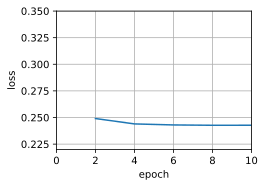

In [17]:
def train_sgd(lr, batch_size, num_epochs=2):
    data_iter, feature_dim = get_data_ch11(batch_size)
    return train_ch11(sgd, None, {'lr': lr}, data_iter, feature_dim, num_epochs)

gd_res = train_sgd(1, 1500, 10)

loss: 0.244, 0.148 sec/epoch


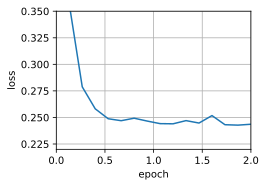

In [18]:
sgd_res = train_sgd(0.005, 1)

loss: 0.245, 0.020 sec/epoch


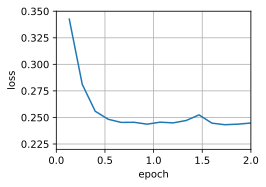

In [19]:
mini1_res = train_sgd(0.4, 100)

loss: 0.246, 0.025 sec/epoch


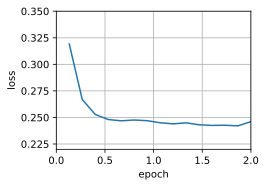

In [20]:
mini2_res = train_sgd(0.05, 10)

现在我们可以比较前四个实验的时间与损失。
可以看出，尽管在处理的样本数方面，随机梯度下降的收敛速度快于梯度下降，但与梯度下降相比，它需要更多的时间来达到同样的损失，因为逐个样本来计算梯度并不那么有效。
小批量随机梯度下降能够平衡收敛速度和计算效率。
大小为10的小批量比随机梯度下降更有效；
大小为100的小批量在运行时间上甚至优于梯度下降。


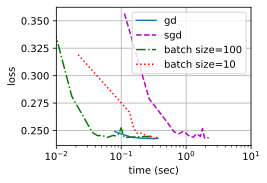

In [21]:
d2l.set_figsize([6, 3])
d2l.plot(*list(map(list, zip(gd_res, sgd_res, mini1_res, mini2_res))),
         'time (sec)', 'loss', xlim=[1e-2, 10],
         legend=['gd', 'sgd', 'batch size=100', 'batch size=10'])
d2l.plt.gca().set_xscale('log')

In [22]:
def train_concise_ch11(trainer_fn, hyperparams, data_iter, num_epochs=4):
    # 初始化模型
    net = nn.Sequential(nn.Linear(5, 1))
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.normal_(m.weight, std=0.01)
    net.apply(init_weights)

    optimizer = trainer_fn(net.parameters(), **hyperparams)
    loss = nn.MSELoss(reduction='none')
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            optimizer.zero_grad()
            out = net(X)
            y = y.reshape(out.shape)
            l = loss(out, y)
            l.mean().backward()
            optimizer.step()
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                # MSELoss计算平方误差时不带系数1/2
                animator.add(n/X.shape[0]/len(data_iter), 
                             (d2l.evaluate_loss(net, data_iter, loss) / 2,))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')

loss: 0.242, 0.034 sec/epoch


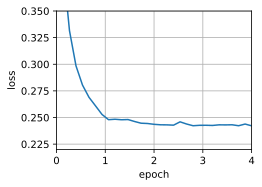

In [23]:
data_iter, col_num = get_data_ch11(10)
trainer = torch.optim.SGD
train_concise_ch11(trainer, {'lr': 0.01}, data_iter)

## Momentum

### Leaky Average

上一节中我们讨论了小批量随机梯度下降作为加速计算的手段。
它也有很好的副作用，即平均梯度减小了方差。
小批量随机梯度下降可以通过以下方式计算：

$$\mathbf{g}_{t, t-1} = \partial_{\mathbf{w}} \frac{1}{|\mathcal{B}_t|} \sum_{i \in \mathcal{B}_t} f(\mathbf{x}_{i}, \mathbf{w}_{t-1}) = \frac{1}{|\mathcal{B}_t|} \sum_{i \in \mathcal{B}_t} \mathbf{h}_{i, t-1}.
$$

为了保持记法简单，在这里我们使用$\mathbf{h}_{i, t-1} = \partial_{\mathbf{w}} f(\mathbf{x}_i, \mathbf{w}_{t-1})$作为样本$i$的随机梯度下降，使用时间$t-1$时更新的权重$t-1$。
如果我们能够从方差减少的影响中受益，甚至超过小批量上的梯度平均值，那很不错。
完成这项任务的一种选择是用*泄漏平均值*（leaky average）取代梯度计算：

$$\mathbf{v}_t = \beta \mathbf{v}_{t-1} + \mathbf{g}_{t, t-1}$$

其中$\beta \in (0, 1)$。
这有效地将瞬时梯度替换为多个“过去”梯度的平均值。
$\mathbf{v}$被称为*动量*（momentum），
它累加了过去的梯度。
为了更详细地解释，让我们递归地将$\mathbf{v}_t$扩展到

$$\begin{aligned}
\mathbf{v}_t = \beta^2 \mathbf{v}_{t-2} + \beta \mathbf{g}_{t-1, t-2} + \mathbf{g}_{t, t-1}
= \ldots, = \sum_{\tau = 0}^{t-1} \beta^{\tau} \mathbf{g}_{t-\tau, t-\tau-1}.
\end{aligned}$$

其中，较大的$\beta$相当于长期平均值，而较小的$\beta$相对于梯度法只是略有修正。
新的梯度替换不再指向特定实例下降最陡的方向，而是指向过去梯度的加权平均值的方向。
这使我们能够实现对单批量计算平均值的大部分好处，而不产生实际计算其梯度的代价。

上述推理构成了"加速"梯度方法的基础，例如具有动量的梯度。
在优化问题条件不佳的情况下（例如，有些方向的进展比其他方向慢得多，类似狭窄的峡谷），"加速"梯度还额外享受更有效的好处。
此外，它们允许我们对随后的梯度计算平均值，以获得更稳定的下降方向。
诚然，即使是对于无噪声凸问题，加速度这方面也是动量如此起效的关键原因之一。

### A Example of Pathological Curvature

为了更好地了解动量法的几何属性，我们复习一下梯度下降，尽管它的目标函数明显不那么令人愉快。
回想我们在 :numref:`sec_gd`中使用了$f(\mathbf{x}) = x_1^2 + 2 x_2^2$，即中度扭曲的椭球目标。
我们通过向$x_1$方向伸展它来进一步扭曲这个函数

$$f(\mathbf{x}) = 0.1 x_1^2 + 2 x_2^2.$$

与之前一样，$f$在$(0, 0)$有最小值，
该函数在$x_1$的方向上*非常*平坦。
让我们看看在这个新函数上执行梯度下降时会发生什么。

epoch 20, x1: -0.943467, x2: -0.000073


c:\Users\Jason Chen\.conda\envs\d2l\lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


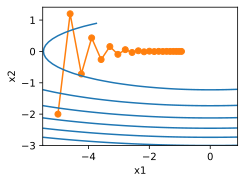

In [4]:
import torch
from d2l import torch as d2l

eta = 0.4
def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

def gd_2d(x1, x2, s1, s2):
    return (x1 - eta * 0.2 * x1, x2 - eta * 4 * x2, 0, 0)

d2l.show_trace_2d(f_2d, d2l.train_2d(gd_2d))

从构造来看，$x_2$方向的梯度比水平$x_1$方向的梯度大得多，变化也快得多。
因此，我们陷入两难：如果选择较小的学习率，我们会确保解不会在$x_2$方向发散，但要承受在$x_1$方向的缓慢收敛。相反，如果学习率较高，我们在$x_1$方向上进展很快，但在$x_2$方向将会发散。
下面的例子说明了即使学习率从$0.4$略微提高到$0.6$，也会发生变化。
$x_1$方向上的收敛有所改善，但整体来看解的质量更差了。


epoch 20, x1: -0.387814, x2: -1673.365109


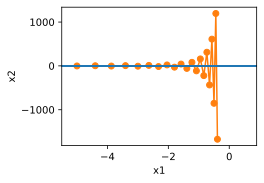

In [5]:
eta = 0.6
d2l.show_trace_2d(f_2d, d2l.train_2d(gd_2d))

*动量法*（momentum）使我们能够解决上面描述的梯度下降问题。
观察上面的优化轨迹，我们可能会直觉到计算过去的平均梯度效果会很好。
毕竟，在$x_1$方向上，这将聚合非常对齐的梯度，从而增加我们在每一步中覆盖的距离。
相反，在梯度振荡的$x_2$方向，由于相互抵消了对方的振荡，聚合梯度将减小步长大小。
使用$\mathbf{v}_t$而不是梯度$\mathbf{g}_t$可以生成以下更新等式：

$$
\begin{aligned}
\mathbf{v}_t &\leftarrow \beta \mathbf{v}_{t-1} + \mathbf{g}_{t, t-1}, \\
\mathbf{x}_t &\leftarrow \mathbf{x}_{t-1} - \eta_t \mathbf{v}_t.
\end{aligned}
$$

请注意，对于$\beta = 0$，我们恢复常规的梯度下降。
在深入研究它的数学属性之前，让我们快速看一下算法在实验中的表现如何。

epoch 20, x1: 0.007188, x2: 0.002553


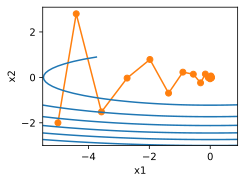

In [6]:
def momentum_2d(x1, x2, v1, v2):
    v1 = beta * v1 + 0.2 * x1
    v2 = beta * v2 + 4 * x2
    return x1 - eta * v1, x2 - eta * v2, v1, v2

eta, beta = 0.6, 0.5
d2l.show_trace_2d(f_2d, d2l.train_2d(momentum_2d))

epoch 20, x1: -0.126340, x2: -0.186632


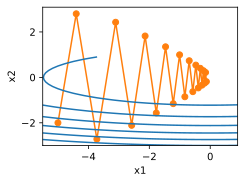

In [7]:
eta, beta = 0.6, 0.25
d2l.show_trace_2d(f_2d, d2l.train_2d(momentum_2d))

### 有效梯度

回想一下$\mathbf{v}_t = \sum_{\tau = 0}^{t-1} \beta^{\tau} \mathbf{g}_{t-\tau, t-\tau-1}$。
极限条件下，$\sum_{\tau=0}^\infty \beta^\tau = \frac{1}{1-\beta}$。
换句话说，不同于在梯度下降或者随机梯度下降中取步长$\eta$，我们选取步长$\frac{\eta}{1-\beta}$，同时处理潜在表现可能会更好的下降方向。
这是集两种好处于一身的做法。
为了说明$\beta$的不同选择的权重效果如何，请参考下面的图表。


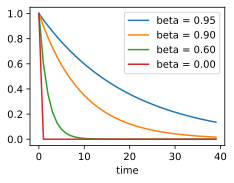

In [8]:
d2l.set_figsize()
betas = [0.95, 0.9, 0.6, 0]
for beta in betas:
    x = torch.arange(40).detach().numpy()
    d2l.plt.plot(x, beta**x, label=f'beta = {beta:.2f}')
d2l.plt.xlabel('time')
d2l.plt.legend();

相比于小批量随机梯度下降，动量方法需要维护一组辅助变量，即速度。
它与梯度以及优化问题的变量具有相同的形状。
在下面的实现中，我们称这些变量为`states`。

In [9]:
# Implement From Scratch
def init_momentum_states(feature_dim):
    v_w = torch.zeros((feature_dim, 1))
    v_b = torch.zeros(1)
    return (v_w, v_b)

In [10]:
def sgd_momentum(params, states, hyperparams):
    for p, v in zip(params, states):
        with torch.no_grad():
            v[:] = hyperparams['momentum'] * v + p.grad
            p[:] -= hyperparams['lr'] * v
        p.grad.data.zero_()

loss: 0.243, 0.029 sec/epoch


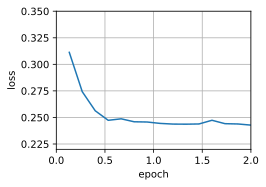

In [11]:
def train_momentum(lr, momentum, num_epochs=2):
    d2l.train_ch11(sgd_momentum, init_momentum_states(feature_dim),
                   {'lr': lr, 'momentum': momentum}, data_iter, feature_dim, num_epochs)
    
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
train_momentum(0.02, 0.5)

当我们将动量超参数`momentum`增加到0.9时，它相当于有效样本数量增加到$\frac{1}{1 - 0.9} = 10$。
我们将学习率略微降至$0.01$，以确保可控。


loss: 0.249, 0.025 sec/epoch


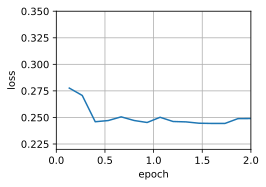

In [12]:
train_momentum(0.01, 0.9)

降低学习率进一步解决了任何非平滑优化问题的困难，将其设置为$0.005$会产生良好的收敛性能。


loss: 0.243, 0.024 sec/epoch


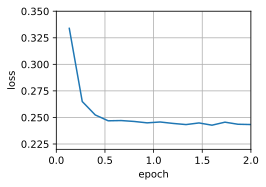

In [15]:
train_momentum(0.005, 0.9)

loss: 0.247, 0.040 sec/epoch


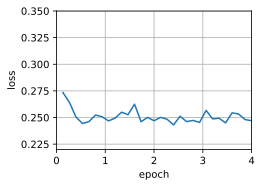

In [16]:
# Concise
trainer = torch.optim.SGD
d2l.train_concise_ch11(trainer, {'lr': 0.005, 'momentum': 0.9}, data_iter)

考虑这个函数

$$h(\mathbf{x}) = \frac{1}{2} \mathbf{x}^\top \mathbf{Q} \mathbf{x} + \mathbf{x}^\top \mathbf{c} + b.$$

这是一个普通的二次函数。
对于正定矩阵$\mathbf{Q} \succ 0$，即对于具有正特征值的矩阵，有最小化器为$\mathbf{x}^* = -\mathbf{Q}^{-1} \mathbf{c}$，最小值为$b - \frac{1}{2} \mathbf{c}^\top \mathbf{Q}^{-1} \mathbf{c}$。
因此我们可以将$h$重写为

$$h(\mathbf{x}) = \frac{1}{2} (\mathbf{x} - \mathbf{Q}^{-1} \mathbf{c})^\top \mathbf{Q} (\mathbf{x} - \mathbf{Q}^{-1} \mathbf{c}) + b - \frac{1}{2} \mathbf{c}^\top \mathbf{Q}^{-1} \mathbf{c}.$$

梯度由$\partial_{\mathbf{x}} f(\mathbf{x}) = \mathbf{Q} (\mathbf{x} - \mathbf{Q}^{-1} \mathbf{c})$给出。
也就是说，它是由$\mathbf{x}$和最小化器之间的距离乘以$\mathbf{Q}$所得出的。
因此，动量法还是$\mathbf{Q} (\mathbf{x}_t - \mathbf{Q}^{-1} \mathbf{c})$的线性组合。

由于$\mathbf{Q}$是正定的，因此可以通过$\mathbf{Q} = \mathbf{O}^\top \boldsymbol{\Lambda} \mathbf{O}$分解为正交（旋转）矩阵$\mathbf{O}$和正特征值的对角矩阵$\boldsymbol{\Lambda}$。
这使我们能够将变量从$\mathbf{x}$更改为$\mathbf{z} := \mathbf{O} (\mathbf{x} - \mathbf{Q}^{-1} \mathbf{c})$，以获得一个非常简化的表达式：

$$h(\mathbf{z}) = \frac{1}{2} \mathbf{z}^\top \boldsymbol{\Lambda} \mathbf{z} + b'.$$

这里$b' = b - \frac{1}{2} \mathbf{c}^\top \mathbf{Q}^{-1} \mathbf{c}$。
由于$\mathbf{O}$只是一个正交矩阵，因此不会真正意义上扰动梯度。
以$\mathbf{z}$表示的梯度下降变成

$$\mathbf{z}_t = \mathbf{z}_{t-1} - \boldsymbol{\Lambda} \mathbf{z}_{t-1} = (\mathbf{I} - \boldsymbol{\Lambda}) \mathbf{z}_{t-1}.$$

这个表达式中的重要事实是梯度下降在不同的特征空间之间不会混合。
也就是说，如果用$\mathbf{Q}$的特征系统来表示，优化问题是以逐坐标顺序的方式进行的。
这在动量法中也适用。

$$\begin{aligned}
\mathbf{v}_t & = \beta \mathbf{v}_{t-1} + \boldsymbol{\Lambda} \mathbf{z}_{t-1} \\
\mathbf{z}_t & = \mathbf{z}_{t-1} - \eta \left(\beta \mathbf{v}_{t-1} + \boldsymbol{\Lambda} \mathbf{z}_{t-1}\right) \\
    & = (\mathbf{I} - \eta \boldsymbol{\Lambda}) \mathbf{z}_{t-1} - \eta \beta \mathbf{v}_{t-1}.
\end{aligned}$$

在这样做的过程中，我们只是证明了以下定理：带有和带有不凸二次函数动量的梯度下降，可以分解为朝二次矩阵特征向量方向坐标顺序的优化。

鉴于上述结果，让我们看看当我们最小化函数$f(x) = \frac{\lambda}{2} x^2$时会发生什么。
对于梯度下降我们有

$$x_{t+1} = x_t - \eta \lambda x_t = (1 - \eta \lambda) x_t.$$

每$|1 - \eta \lambda| < 1$时，这种优化以指数速度收敛，因为在$t$步之后我们可以得到$x_t = (1 - \eta \lambda)^t x_0$。
这显示了在我们将学习率$\eta$提高到$\eta \lambda = 1$之前，收敛率最初是如何提高的。
超过该数值之后，梯度开始发散，对于$\eta \lambda > 2$而言，优化问题将会发散。

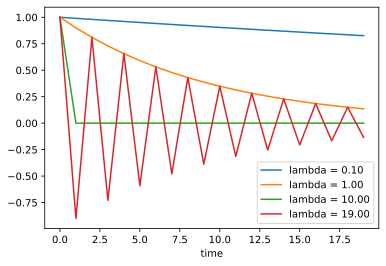

In [17]:
lambdas = [0.1, 1, 10, 19]
eta = 0.1
d2l.set_figsize((6, 4))
for lam in lambdas:
    t = torch.arange(20).detach().numpy()
    d2l.plt.plot(t, (1 - eta * lam) ** t, label=f'lambda = {lam:.2f}')
d2l.plt.xlabel('time')
d2l.plt.legend();

## AdaGrad

假设我们正在训练一个语言模型。
为了获得良好的准确性，我们大多希望在训练的过程中降低学习率，速度通常为$\mathcal{O}(t^{-\frac{1}{2}})$或更低。
现在讨论关于稀疏特征（即只在偶尔出现的特征）的模型训练，这对自然语言来说很常见。
例如，我们看到“预先条件”这个词比“学习”这个词的可能性要小得多。
但是，它在计算广告学和个性化协同过滤等其他领域也很常见。

只有在这些不常见的特征出现时，与其相关的参数才会得到有意义的更新。
鉴于学习率下降，我们可能最终会面临这样的情况：常见特征的参数相当迅速地收敛到最佳值，而对于不常见的特征，我们仍缺乏足够的观测以确定其最佳值。
换句话说，学习率要么对于常见特征而言降低太慢，要么对于不常见特征而言降低太快。

解决此问题的一个方法是记录我们看到特定特征的次数，然后将其用作调整学习率。
即我们可以使用大小为$\eta_i = \frac{\eta_0}{\sqrt{s(i, t) + c}}$的学习率，而不是$\eta = \frac{\eta_0}{\sqrt{t + c}}$。
在这里$s(i, t)$计下了我们截至$t$时观察到功能$i$的次数。
这其实很容易实施且不产生额外损耗。

AdaGrad算法通过将粗略的计数器$s(i, t)$替换为先前观察所得梯度的平方之和来解决这个问题。
它使用$s(i, t+1) = s(i, t) + \left(\partial_i f(\mathbf{x})\right)^2$来调整学习率。
这有两个好处：首先，我们不再需要决定梯度何时算足够大。
其次，它会随梯度的大小自动变化。通常对应于较大梯度的坐标会显著缩小，而其他梯度较小的坐标则会得到更平滑的处理。
在实际应用中，它促成了计算广告学及其相关问题中非常有效的优化程序。
但是，它遮盖了AdaGrad固有的一些额外优势，这些优势在预处理环境中很容易被理解。

我们使用变量$\mathbf{s}_t$来累加过去的梯度方差，如下所示：

$$\begin{aligned}
    \mathbf{g}_t & = \partial_{\mathbf{w}} l(y_t, f(\mathbf{x}_t, \mathbf{w})), \\
    \mathbf{s}_t & = \mathbf{s}_{t-1} + \mathbf{g}_t^2, \\
    \mathbf{w}_t & = \mathbf{w}_{t-1} - \frac{\eta}{\sqrt{\mathbf{s}_t + \epsilon}} \cdot \mathbf{g}_t.
\end{aligned}$$

在这里，操作是按照坐标顺序应用。
也就是说，$\mathbf{v}^2$有条目$v_i^2$。
同样，$\frac{1}{\sqrt{v}}$有条目$\frac{1}{\sqrt{v_i}}$，
并且$\mathbf{u} \cdot \mathbf{v}$有条目$u_i v_i$。
与之前一样，$\eta$是学习率，$\epsilon$是一个为维持数值稳定性而添加的常数，用来确保我们不会除以$0$。
最后，我们初始化$\mathbf{s}_0 = \mathbf{0}$。

就像在动量法中我们需要跟踪一个辅助变量一样，在AdaGrad算法中，我们允许每个坐标有单独的学习率。
与SGD算法相比，这并没有明显增加AdaGrad的计算代价，因为主要计算用在$l(y_t, f(\mathbf{x}_t, \mathbf{w}))$及其导数。

请注意，在$\mathbf{s}_t$中累加平方梯度意味着$\mathbf{s}_t$基本上以线性速率增长（由于梯度从最初开始衰减，实际上比线性慢一些）。
这产生了一个学习率$\mathcal{O}(t^{-\frac{1}{2}})$，但是在单个坐标的层面上进行了调整。

眼下让我们先看看它在二次凸问题中的表现如何。
我们仍然以同一函数为例：

$$f(\mathbf{x}) = 0.1 x_1^2 + 2 x_2^2.$$

我们将使用与之前相同的学习率来实现AdaGrad算法，即$\eta = 0.4$。
可以看到，自变量的迭代轨迹较平滑。
但由于$\boldsymbol{s}_t$的累加效果使学习率不断衰减，自变量在迭代后期的移动幅度较小。

In [1]:
import math
import torch
from d2l import torch as d2l

epoch 20, x1: -2.382563, x2: -0.158591


c:\Users\Jason Chen\.conda\envs\d2l\lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


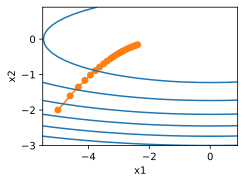

In [4]:
def adagrad_2d(x1, x2, s1, s2):
    eps = 1e-6
    g1, g2 = 0.2 * x1, 4 * x2
    s1 += g1 ** 2
    s2 += g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta = 0.4
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

epoch 20, x1: -0.002295, x2: -0.000000


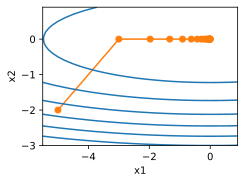

In [5]:
eta = 2
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

In [6]:
# Implementation From Scratch
def init_adagrad_states(feature_dim):
    s_w = torch.zeros((feature_dim, 1))
    s_b = torch.zeros(1)
    return (s_w, s_b)

def adagrad(params, states, hyperparams):
    eps = 1e-6
    for p, s in zip(params, states):
        with torch.no_grad():
            s[:] += torch.square(p.grad)
            p[:] -= hyperparams['lr'] * p.grad / torch.sqrt(s + eps)
        p.grad.data.zero_()

loss: 0.245, 0.029 sec/epoch


([0.03488421440124512,
  0.06123638153076172,
  0.0888524055480957,
  0.1158454418182373,
  0.15932416915893555,
  0.1838970184326172,
  0.21468758583068848,
  0.24680542945861816,
  0.27442002296447754,
  0.31084704399108887,
  0.33753442764282227,
  0.36550331115722656,
  0.3897435665130615,
  0.4181075096130371,
  0.43657612800598145],
 [0.27217330094178516,
  0.2548195006052653,
  0.2468976650238037,
  0.24740701774756113,
  0.24600737444559734,
  0.2471584881146749,
  0.24602129594484964,
  0.24286102199554443,
  0.2436905990044276,
  0.2438011415799459,
  0.2480515999396642,
  0.24229483437538146,
  0.24209379633267722,
  0.24286359133323035,
  0.2446998557448387])

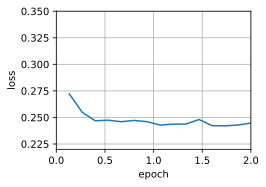

In [8]:
data_iter, feature_dim = d2l.get_data_ch11()
d2l.train_ch11(adagrad, init_adagrad_states(feature_dim), {'lr': 0.1}, data_iter, feature_dim)

loss: 0.242, 0.044 sec/epoch


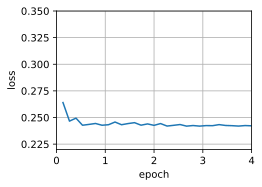

In [9]:
# Concise
trainer = torch.optim.Adagrad
d2l.train_concise_ch11(trainer, {'lr': 0.1}, data_iter)

证明如下:  

设 $\mathbf{c}$ 和 $\mathbf{\delta}$ 为任意向量，$\mathbf{U}$ 为正交矩阵，则有：  

$$
\mathbf{c} - \mathbf{\delta}\|_2 = \sqrt{(\mathbf{c} - \mathbf{\delta})^T(\mathbf{c} - \mathbf{\delta})}  
$$

我们可以用正交矩阵 $\mathbf{U}$ 进行变换：  

$$
= \sqrt{(\mathbf{U}\mathbf{c} - \mathbf{U}\mathbf{\delta})^T(\mathbf{U}\mathbf{c} - \mathbf{U}\mathbf{\delta})}  
$$  

由于 $\mathbf{U}$ 是正交矩阵，因此有 $\mathbf{U}^T\mathbf{U} = \mathbf{I}$，上式化简为：  

$$  
\|\mathbf{c} - \mathbf{\delta}\|_2 = \sqrt{(\mathbf{U}\mathbf{c} - \mathbf{U}\mathbf{\delta})^T(\mathbf{U}\mathbf{c} - \mathbf{U}\mathbf{\delta})} = \|\mathbf{U}\mathbf{c} - \mathbf{U}\mathbf{\delta}\|_2  
$$  

这意味着，当我们对向量 $\mathbf{c}$ 和 $\mathbf{\delta}$ 进行正交变换时，它们之间的欧氏距离不会发生改变。换言之，正交变换不会影响向量之间的相对偏离程度。这在一些数值计算和信号处理的应用中十分重要，因为它保证了在进行正交变换后，原始信号的扰动程度不会改变。

epoch 20, x1: -0.002295, x2: -22.915399


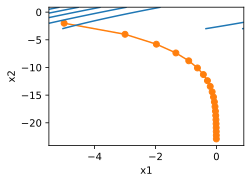

In [10]:
def adagrad_2d(x1, x2, s1, s2):
    eps = 1e-6
    g1, g2 = 4.2 * x1,  - 3.8 * x2
    s1 += g1 ** 2
    s2 += g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * (x1 + x2) ** 2 + 2 * (x1 - x2) ** 2

eta = 2
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

### [陈述与证明](https://en.wikipedia.org/wiki/Gershgorin_circle_theorem)

设 $ A $ 是一个 $ n \times n $ 的复矩阵，其元素为 $ a_{ij} $。对于 $ i \in \{1, \dots, n\} $，令 $ R_{i} $ 为第 $ i $ 行非对角元素绝对值之和：  
$$  
R_{i} = \sum_{j \neq i} |a_{ij}|.  
$$  
令 $ D(a_{ii}, R_{i}) \subseteq \mathbb{C} $ 为以 $ a_{ii} $ 为中心，半径为 $ R_{i} $ 的闭圆盘。这样的圆盘称为Gershgorin圆盘。  

**定理**：每个 $ A $ 的特征值都位于至少一个Gershgorin圆盘 $ D(a_{ii}, R_{i}) $ 内。  

**证明**：设 $ \lambda $ 是 $ A $ 的一个特征值，对应的特征向量为 $ x = (x_{j}) $。找到 $ i $ 使得 $ x $ 中绝对值最大的元素为 $ x_{i} $。由于 $ Ax = \lambda x $，特别地，我们取该方程的第 $ i $ 个分量，得到：  
$$  
\sum_{j} a_{ij} x_{j} = \lambda x_{i}.  
$$  
将 $ a_{ii} $ 移到等式的另一边：  
$$  
\sum_{j \neq i} a_{ij} x_{j} = (\lambda - a_{ii}) x_{i}.  
$$  
因此，应用三角不等式，并回忆到 $ \frac{|x_{j}|}{|x_{i}|} \leq 1 $（基于我们选择的 $ i $），我们有：  
$$  
|\lambda - a_{ii}| = \left| \sum_{j \neq i} \frac{a_{ij} x_{j}}{x_{i}} \right| \leq \sum_{j \neq i} \left| \frac{a_{ij} x_{j}}{x_{i}} \right| = \sum_{j \neq i} |a_{ij}| \frac{|x_{j}|}{|x_{i}|} \leq \sum_{j \neq i} |a_{ij}| = R_{i}.  
$$

## RMSProp

`adagrad`中的关键问题之一，是学习率按预定时间表$\mathcal{O}(t^{-\frac{1}{2}})$显著降低。
虽然这通常适用于凸问题，但对于深度学习中遇到的非凸问题，可能并不理想。
但是，作为一个预处理器，Adagrad算法按坐标顺序的适应性是非常可取的。

问题在于，Adagrad算法将梯度$\mathbf{g}_t$的平方累加成状态矢量$\mathbf{s}_t = \mathbf{s}_{t-1} + \mathbf{g}_t^2$。
因此，由于缺乏规范化，没有约束力，$\mathbf{s}_t$持续增长，几乎上是在算法收敛时呈线性递增。

解决此问题的一种方法是使用$\mathbf{s}_t / t$。
对$\mathbf{g}_t$的合理分布来说，它将收敛。
遗憾的是，限制行为生效可能需要很长时间，因为该流程记住了值的完整轨迹。
另一种方法是按动量法中的方式使用泄漏平均值，即$\mathbf{s}_t \leftarrow \gamma \mathbf{s}_{t-1} + (1-\gamma) \mathbf{g}_t^2$，其中参数$\gamma > 0$。
保持所有其它部分不变就产生了RMSProp算法。

让我们详细写出这些方程式。

$$\begin{aligned}
    \mathbf{s}_t & \leftarrow \gamma \mathbf{s}_{t-1} + (1 - \gamma) \mathbf{g}_t^2, \\
    \mathbf{x}_t & \leftarrow \mathbf{x}_{t-1} - \frac{\eta}{\sqrt{\mathbf{s}_t + \epsilon}} \odot \mathbf{g}_t.
\end{aligned}$$

常数$\epsilon > 0$通常设置为$10^{-6}$，以确保我们不会因除以零或步长过大而受到影响。
鉴于这种扩展，我们现在可以自由控制学习率$\eta$，而不考虑基于每个坐标应用的缩放。
就泄漏平均值而言，我们可以采用与之前在动量法中适用的相同推理。
扩展$\mathbf{s}_t$定义可获得

$$
\begin{aligned}
\mathbf{s}_t & = (1 - \gamma) \mathbf{g}_t^2 + \gamma \mathbf{s}_{t-1} \\
& = (1 - \gamma) \left(\mathbf{g}_t^2 + \gamma \mathbf{g}_{t-1}^2 + \gamma^2 \mathbf{g}_{t-2} + \ldots, \right).
\end{aligned}
$$

同之前在`momentum`小节一样，我们使用$1 + \gamma + \gamma^2 + \ldots, = \frac{1}{1-\gamma}$。
因此，权重总和标准化为$1$且观测值的半衰期为$\gamma^{-1}$。
让我们图像化各种数值的$\gamma$在过去40个时间步长的权重。


In [1]:
import math
import torch
from d2l import torch as d2l

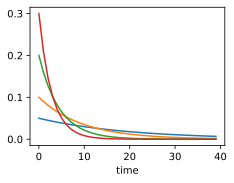

In [2]:
d2l.set_figsize()
gammas = [0.95, 0.9, 0.8, 0.7]
for gamma in gammas:
    x = torch.arange(40).detach().numpy()
    d2l.plt.plot(x, (1-gamma) * gamma ** x, label=f'gamma = {gamma:.2f}')
d2l.plt.xlabel('time');

epoch 20, x1: -0.010599, x2: 0.000000


c:\Users\Jason Chen\.conda\envs\d2l\lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


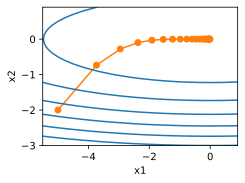

In [3]:
def rmsprop_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6
    s1 = gamma * s1 + (1 - gamma) * g1 ** 2
    s2 = gamma * s2 + (1 - gamma) * g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta, gamma = 0.4, 0.9
d2l.show_trace_2d(f_2d, d2l.train_2d(rmsprop_2d))

In [4]:
# Implement From Scratch
def init_rmsprop_states(feature_dim):
    s_w = torch.zeros((feature_dim, 1))
    s_b = torch.zeros(1)
    return (s_w, s_b)

In [8]:
def rmsprop(params, states, hyperparams):
    gamma, eps = hyperparams['gamma'], 1e-6
    for p, s in zip(params, states):
        with torch.no_grad():
            s[:] = gamma * s + (1 - gamma) * torch.square(p.grad)
            p[:] -= hyperparams['lr'] * p.grad / torch.sqrt(s + eps)  # 注意这里不能是math.sqrt
        p.grad.data.zero_()

我们将初始学习率设置为0.01，加权项$\gamma$设置为0.9。
也就是说，$\mathbf{s}$累加了过去的$1/(1-\gamma) = 10$次平方梯度观测值的平均值。

loss: 0.246, 0.034 sec/epoch


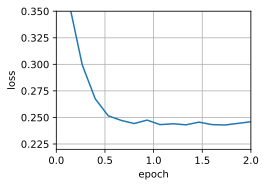

In [9]:
data_iter, feature_dim = d2l.get_data_ch11()
d2l.train_ch11(rmsprop, init_rmsprop_states(feature_dim), {'lr': 0.01, 'gamma': 0.9}, data_iter, feature_dim);

loss: 0.244, 0.041 sec/epoch


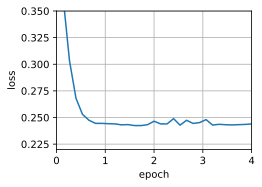

In [12]:
trainer = torch.optim.RMSprop
d2l.train_concise_ch11(trainer, {'lr': 0.01, 'alpha': 0.9}, data_iter)

loss: nan, 0.039 sec/epoch


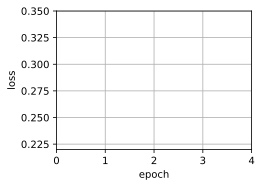

In [13]:
d2l.train_concise_ch11(trainer, {'lr': 0.01, 'alpha': 1}, data_iter)

### Comparison

epoch 20, x1: -0.305981, x2: -12.000000


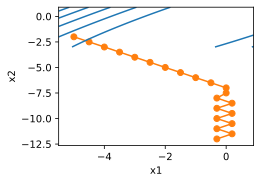

In [27]:
def rmsprop_2d(x1, x2, s1, s2):
    gamma, eps = 0, 1e-6
    g1, g2 = 4.2 * x1,  - 3.8 * x2
    s1 = gamma * s1 + (1 - gamma) * g1 ** 2
    s2 = gamma * s2 + (1 - gamma) * g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * (x1 + x2) ** 2 + 2 * (x1 - x2) ** 2

eta = 0.5
d2l.show_trace_2d(f_2d, d2l.train_2d(rmsprop_2d))

epoch 20, x1: -0.000001, x2: -14.435128


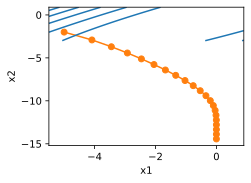

In [28]:
def rmsprop_2d(x1, x2, s1, s2):
    gamma, eps = 0.7, 1e-6
    g1, g2 = 4.2 * x1,  - 3.8 * x2
    s1 = gamma * s1 + (1 - gamma) * g1 ** 2
    s2 = gamma * s2 + (1 - gamma) * g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * (x1 + x2) ** 2 + 2 * (x1 - x2) ** 2

eta = 0.5
d2l.show_trace_2d(f_2d, d2l.train_2d(rmsprop_2d))

epoch 20, x1: -0.000343, x2: 0.000000


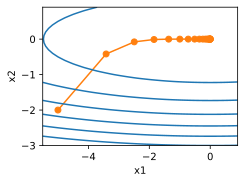

In [21]:
def rmsprop_2d(x1, x2, s1, s2):
    gamma, eps = 0.9, 1e-6
    g1, g2 = 0.2 * x1,  4 * x2
    s1 = gamma * s1 + (1 - gamma) * g1 ** 2
    s2 = gamma * s2 + (1 - gamma) * g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * (x1) ** 2 + 2 * (x2) ** 2

eta = 0.5
d2l.show_trace_2d(f_2d, d2l.train_2d(rmsprop_2d))

## Adadelta

Adadelta是AdaGrad的另一种变体，
主要区别在于前者减少了学习率适应坐标的数量。

此外，广义上Adadelta被称为没有学习率，因为它使用变化量本身作为未来变化的校准。

简而言之，Adadelta使用两个状态变量，$\mathbf{s}_t$用于存储梯度二阶导数的泄露平均值，$\Delta\mathbf{x}_t$用于存储模型本身中参数变化二阶导数的泄露平均值。

以下是Adadelta的技术细节。鉴于参数$\gamma$改成了$\rho$，我们获得了与 `rmsprop`类似的以下泄漏更新：

$$\begin{aligned}
    \mathbf{s}_t & = \rho \mathbf{s}_{t-1} + (1 - \rho) \mathbf{g}_t^2.
\end{aligned}$$

与`rmsprop`的区别在于，我们使用重新缩放的梯度$\mathbf{g}_t'$执行更新，即

$$\begin{aligned}
    \mathbf{x}_t  & = \mathbf{x}_{t-1} - \mathbf{g}_t'. \\
\end{aligned}$$

那么，调整后的梯度$\mathbf{g}_t'$是什么？我们可以按如下方式计算它：

$$\begin{aligned}
    \mathbf{g}_t' & = \frac{\sqrt{\Delta\mathbf{x}_{t-1} + \epsilon}}{\sqrt{{\mathbf{s}_t + \epsilon}}} \odot \mathbf{g}_t, \\
\end{aligned}$$

其中$\Delta \mathbf{x}_{t-1}$是重新缩放梯度的平方$\mathbf{g}_t'$的泄漏平均值。我们将$\Delta \mathbf{x}_{0}$初始化为$0$，然后在每个步骤中使用$\mathbf{g}_t'$更新它，即

$$\begin{aligned}
    \Delta \mathbf{x}_t & = \rho \Delta\mathbf{x}_{t-1} + (1 - \rho) {\mathbf{g}_t'}^2,
\end{aligned}$$

其中$\epsilon$（例如$10^{-5}$这样的小值）是为了保持数字稳定性而加入的。

In [29]:
import torch
from d2l import torch as d2l

def init_adadelta_states(feature_dim):
    s_w, s_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    delta_w, delta_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    return ((s_w, delta_w), (s_b, delta_b))

def adadelta(params, states, hyperparams):
    rho, eps = hyperparams['rho'], 1e-5
    for p, (s, delta) in zip(params, states):
        with torch.no_grad():
            # 解释一下：通过[:]我们可以实现对参数的就地更新而非新建变量
            s[:] = rho * s + (1 - rho) * p.grad ** 2
            g = (torch.sqrt(delta + eps) / torch.sqrt(s + eps)) * p.grad
            p[:] -= g
            delta[:] = rho * delta + (1 - rho) * g ** 2
        p.grad.data.zero_()

loss: 0.243, 0.042 sec/epoch


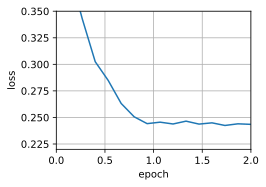

In [32]:
data_iter, feature_dim = d2l.get_data_ch11()
# 选择rho=0.9相当于10个半衰期 (1/1-rho)
d2l.train_ch11(adadelta, init_adadelta_states(feature_dim), {'rho': 0.9}, data_iter, feature_dim);

loss: 0.243, 0.045 sec/epoch


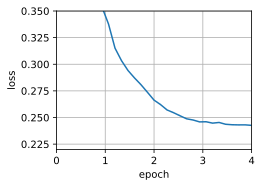

In [33]:
# Concise
trainer = torch.optim.Adadelta
d2l.train_concise_ch11(trainer, {'rho': 0.9}, data_iter)

### Choose $\rho$ 

loss: 0.245, 0.043 sec/epoch


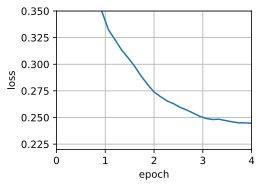

In [34]:
d2l.train_concise_ch11(trainer, {'rho': 0.1}, data_iter)

loss: 0.259, 0.040 sec/epoch


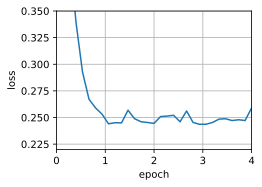

In [36]:
d2l.train_concise_ch11(trainer, {'rho': 0}, data_iter)

## Adam

本章我们已经学习了许多有效优化的技术。
在本节讨论之前，我们先详细回顾一下这些技术：

* 在`sgd`中，我们学习了：随机梯度下降在解决优化问题时比梯度下降更有效。
* 在`minibatch-sgd`中，我们学习了：在一个小批量中使用更大的观测值集，可以通过向量化提供额外效率。这是高效的多机、多GPU和整体并行处理的关键。
* 在`momentum`中我们添加了一种机制，用于汇总过去梯度的历史以加速收敛。
* 在`adagrad`中，我们通过对每个坐标缩放来实现高效计算的预处理器。
* 在`rmsprop`中，我们通过学习率的调整来分离每个坐标的缩放。

Adam算法将所有这些技术汇总到一个高效的学习算法中。
不出预料，作为深度学习中使用的更强大和有效的优化算法之一，它非常受欢迎。
但是它并非没有问题，有时Adam算法可能由于方差控制不良而发散。
在完善工作中，`Zaheer.Reddi.Sachan.ea.2018`给Adam算法提供了一个称为Yogi的热补丁来解决这些问题。

Adam算法的关键组成部分之一是：它使用指数加权移动平均值来估算梯度的动量和二次矩，即它使用状态变量

$$\begin{aligned}
    \mathbf{v}_t & \leftarrow \beta_1 \mathbf{v}_{t-1} + (1 - \beta_1) \mathbf{g}_t, \\
    \mathbf{s}_t & \leftarrow \beta_2 \mathbf{s}_{t-1} + (1 - \beta_2) \mathbf{g}_t^2.
\end{aligned}$$

这里$\beta_1$和$\beta_2$是非负加权参数。
常将它们设置为$\beta_1 = 0.9$和$\beta_2 = 0.999$。
也就是说，方差估计的移动远远慢于动量估计的移动。
注意，如果我们初始化$\mathbf{v}_0 = \mathbf{s}_0 = 0$，就会获得一个相当大的初始偏差。
我们可以通过使用$\sum_{i=0}^t \beta^i = \frac{1 - \beta^t}{1 - \beta}$来解决这个问题。
相应地，标准化状态变量由下式获得

$$\hat{\mathbf{v}}_t = \frac{\mathbf{v}_t}{1 - \beta_1^t} \text{ and } \hat{\mathbf{s}}_t = \frac{\mathbf{s}_t}{1 - \beta_2^t}.$$

有了正确的估计，我们现在可以写出更新方程。
首先，我们以非常类似于RMSProp算法的方式重新缩放梯度以获得

$$\mathbf{g}_t' = \frac{\eta \hat{\mathbf{v}}_t}{\sqrt{\hat{\mathbf{s}}_t} + \epsilon}.$$

与RMSProp不同，我们的更新使用动量$\hat{\mathbf{v}}_t$而不是梯度本身。
此外，由于使用$\frac{1}{\sqrt{\hat{\mathbf{s}}_t} + \epsilon}$而不是$\frac{1}{\sqrt{\hat{\mathbf{s}}_t + \epsilon}}$进行缩放，两者会略有差异。
前者在实践中效果略好一些，因此与RMSProp算法有所区分。
通常，我们选择$\epsilon = 10^{-6}$，这是为了在数值稳定性和逼真度之间取得良好的平衡。

最后，我们简单更新：

$$\mathbf{x}_t \leftarrow \mathbf{x}_{t-1} - \mathbf{g}_t'.$$

回顾Adam算法，它的设计灵感很清楚：
首先，动量和规模在状态变量中清晰可见，
它们相当独特的定义使我们移除偏项（这可以通过稍微不同的初始化和更新条件来修正）。
其次，RMSProp算法中两项的组合都非常简单。
最后，明确的学习率$\eta$使我们能够控制步长来解决收敛问题。

In [2]:
import torch
from d2l import torch as d2l

def init_adam_states(feature_dim):
    v_w, v_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    s_w, s_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    return ((v_w, s_w), (v_b, s_b))

def adam(params, states, hyperparams):
    beta1, beta2, eps = 0.99, 0.999, 1e-6
    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            v[:] = beta1 * v + (1 - beta1) * p.grad
            s[:] = beta2 * s + (1 - beta2) * p.grad ** 2
            v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
            s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
            p[:] -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr) + eps)
        p.grad.data.zero_()
    hyperparams['t'] += 1

loss: 0.247, 0.045 sec/epoch


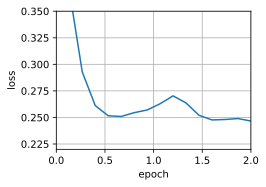

In [3]:
data_iter, feature_dim = d2l.get_data_ch11()
d2l.train_ch11(adam, init_adam_states(feature_dim), {'lr': 0.01,'t': 1}, data_iter, feature_dim);

loss: 0.246, 0.045 sec/epoch


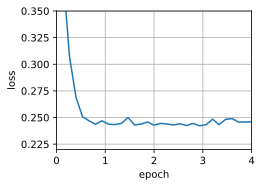

In [4]:
trainer = torch.optim.Adam
d2l.train_concise_ch11(trainer, {'lr': 0.01}, data_iter)

### Yogi


Adam算法也存在一些问题：
即使在凸环境下，当$\mathbf{s}_t$的二次矩估计值爆炸时，它可能无法收敛。
`Zaheer.Reddi.Sachan.ea.2018`为$\mathbf{s}_t$提出了的改进更新和参数初始化。
论文中建议我们重写Adam算法更新如下：

$$\mathbf{s}_t \leftarrow \mathbf{s}_{t-1} + (1 - \beta_2) \left(\mathbf{g}_t^2 - \mathbf{s}_{t-1}\right).$$

每当$\mathbf{g}_t^2$具有值很大的变量或更新很稀疏时，$\mathbf{s}_t$可能会太快地“忘记”过去的值。
一个有效的解决方法是将$\mathbf{g}_t^2 - \mathbf{s}_{t-1}$替换为$\mathbf{g}_t^2 \odot \mathop{\mathrm{sgn}}(\mathbf{g}_t^2 - \mathbf{s}_{t-1})$。
这就是Yogi更新，现在更新的规模不再取决于偏差的量。

$$\mathbf{s}_t \leftarrow \mathbf{s}_{t-1} + (1 - \beta_2) \mathbf{g}_t^2 \odot \mathop{\mathrm{sgn}}(\mathbf{g}_t^2 - \mathbf{s}_{t-1}).$$

论文中，作者还进一步建议用更大的初始批量来初始化动量，而不仅仅是初始的逐点估计。

loss: 0.245, 0.060 sec/epoch


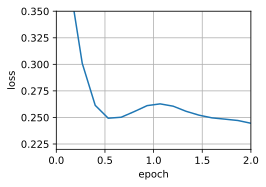

In [5]:
def yogi(params, states, hyperparams):
    beta1, beta2, eps = 0.99, 0.999, 1e-6
    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            v[:] = beta1 * v + (1 - beta1) * p.grad
            s[:] = s + (1 - beta2) * torch.sign(torch.square(p.grad) - s) * torch.square(p.grad)
            v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
            s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
            p[:] -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr) + eps)

        p.grad.data.zero_()
    hyperparams['t'] += 1

data_iter, feature_dim = d2l.get_data_ch11()
d2l.train_ch11(yogi, init_adam_states(feature_dim), {'lr': 0.01, 't': 1}, data_iter, feature_dim);      


## Lr-Scheduler

到目前为止，我们主要关注如何更新权重向量的优化算法，而不是它们的更新速率。
然而，调整学习率通常与实际算法同样重要，有如下几方面需要考虑：

* 首先，学习率的大小很重要。如果它太大，优化就会发散；如果它太小，训练就会需要过长时间，或者我们最终只能得到次优的结果。我们之前看到问题的条件数很重要。直观地说，这是最不敏感与最敏感方向的变化量的比率。
* 其次，衰减速率同样很重要。如果学习率持续过高，我们可能最终会在最小值附近弹跳，从而无法达到最优解。简而言之，我们希望速率衰减，但要比$\mathcal{O}(t^{-\frac{1}{2}})$慢，这样能成为解决凸问题的不错选择。
* 另一个同样重要的方面是初始化。这既涉及参数最初的设置方式，又关系到它们最初的演变方式。这被戏称为*预热*（warmup），即我们最初开始向着解决方案迈进的速度有多快。一开始的大步可能没有好处，特别是因为最初的参数集是随机的。最初的更新方向可能也是毫无意义的。
* 最后，还有许多优化变体可以执行周期性学习率调整。这超出了本章的范围，我们建议读者阅读`Izmailov.Podoprikhin.Garipov.ea.2018`来了解个中细节。例如，如何通过对整个路径参数求平均值来获得更好的解。

鉴于管理学习率需要很多细节，因此大多数深度学习框架都有自动应对这个问题的工具。
在本章中，我们将梳理不同的调度策略对准确性的影响，并展示如何通过*学习率调度器*（learning rate scheduler）来有效管理。

我们从一个简单的问题开始，这个问题可以轻松计算，但足以说明要义。
为此，我们选择了一个稍微现代化的LeNet版本（激活函数使用`relu`而不是`sigmoid`，汇聚层使用最大汇聚层而不是平均汇聚层），并应用于Fashion-MNIST数据集。
此外，我们混合网络以提高性能。

由于大多数代码都是标准的，我们只介绍基础知识，而不做进一步的详细讨论。

In [26]:
import math
import torch
from torch import nn
from torch.optim import lr_scheduler
from d2l import torch as d2l

def net_fn():
    model = nn.Sequential(
        nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
        nn.Linear(120, 84), nn.ReLU(),
        nn.Linear(84, 10)
    )
    return model

loss = nn.CrossEntropyLoss()
device = d2l.try_gpu()

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

def train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
          scheduler=None):
    net.to(device)
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train_acc', 'test acc'])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)  # train_loss,train_acc,num_examples
        for i, (X, y) in enumerate(train_iter):
            net.train()
            trainer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            train_loss = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % 50 == 0:
                animator.add(epoch + i / len(train_iter),
                             (train_loss, train_acc, None))

        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))

        if scheduler:
            if scheduler.__class__.__name__ in ['MultiStepLR', 'StepLR', 'ExponentialLR', 'PolynomialLR']:
                # 使用 PyTorch 内置的调度器
                scheduler.step()
            else:
                # 使用自定义定义的调度器
                for param_group in trainer.param_groups:
                    param_group['lr'] = scheduler(epoch)

        
    print(f'train loss {train_loss:.3f}, train acc {train_acc:.3f}, test acc {test_acc:.3f}')

train loss 0.184, train acc 0.929, test acc 0.893


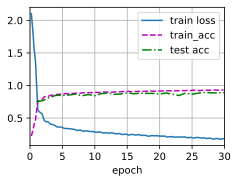

In [8]:
lr, num_epochs = 0.3, 30
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device)

我们可以在每个迭代轮数（甚至在每个小批量）之后向下调整学习率。
例如，以动态的方式来响应优化的进展情况。

In [10]:
lr = 0.1
trainer.param_groups[0]['lr'] = lr
print(f'learning rate is now {trainer.param_groups[0]["lr"]:.2f}')

learning rate is now 0.10


更通常而言，我们应该定义一个调度器。
当调用更新次数时，它将返回学习率的适当值。
让我们定义一个简单的方法，将学习率设置为$\eta = \eta_0 (t + 1)^{-\frac{1}{2}}$。


In [19]:
class SquareRootScheduler:
    def __init__(self, lr=0.1):
        self.lr = lr
    
    def __call__(self, num_update):
        return self.lr * pow(num_update + 1.0, -0.5)
    
    def __model__(self):
        return None

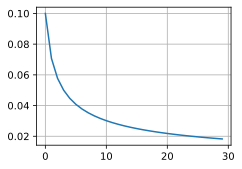

In [20]:
scheduler = SquareRootScheduler(lr=0.1)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

train loss 0.270, train acc 0.902, test acc 0.880


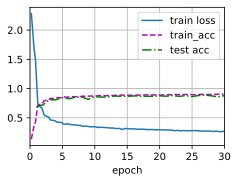

In [21]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device, scheduler)

虽然我们不可能涵盖所有类型的学习率调度器，但我们会尝试在下面简要概述常用的策略：多项式衰减和分段常数表。
此外，余弦学习率调度在实践中的一些问题上运行效果很好。
在某些问题上，最好在使用较高的学习率之前预热优化器。


### Single Factor Scheduler

多项式衰减的一种替代方案是乘法衰减，即$\eta_{t+1} \leftarrow \eta_t \cdot \alpha$其中$\alpha \in (0, 1)$。
为了防止学习率衰减到一个合理的下界之下，
更新方程经常修改为$\eta_{t+1} \leftarrow \mathop{\mathrm{max}}(\eta_{\mathrm{min}}, \eta_t \cdot \alpha)$。


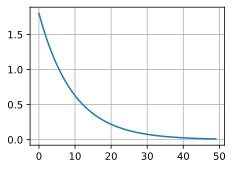

In [22]:
class FactorScheduler:
    def __init__(self, factor=1, stop_factor_lr=1e-7, base_lr = 0.1):
        self.factor = factor
        self.stop_factor_lr = stop_factor_lr
        self.base_lr = base_lr

    def __call__(self, num_update):
        self.base_lr = max(self.stop_factor_lr, self.base_lr * self.factor)
        return self.base_lr
    
    def __model__(self):
        return None
    
scheduler = FactorScheduler(factor=0.9, stop_factor_lr=1e-2, base_lr=2.0)
d2l.plot(torch.arange(50), [scheduler(t) for t in range(50)])

### Multiple Factors Scheduler

训练深度网络的常见策略之一是保持学习率为一组分段的常量，并且不时地按给定的参数对学习率做乘法衰减。
具体地说，给定一组降低学习率的时间点，例如$s = \{5, 10, 20\}$，
每当$t \in s$时，降低$\eta_{t+1} \leftarrow \eta_t \cdot \alpha$。
假设每步中的值减半，我们可以按如下方式实现这一点。


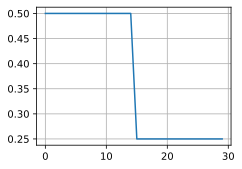

In [13]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
scheduler = lr_scheduler.MultiStepLR(trainer, milestones=[15, 30], gamma=0.5)

def get_lr(trainer, scheduler):
    lr = scheduler.get_last_lr()[0]
    trainer.step()
    scheduler.step()
    return lr

d2l.plot(torch.arange(num_epochs), [get_lr(trainer, scheduler) for t in range(num_epochs)])

train loss 0.186, train acc 0.931, test acc 0.896


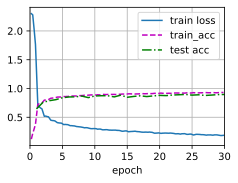

In [14]:
train(net, train_iter, test_iter, num_epochs, loss, trainer, device, scheduler)

### Cosine Annealing

余弦调度器是`Loshchilov.Hutter.2016`提出的一种启发式算法。
它所依据的观点是：我们可能不想在一开始就太大地降低学习率，而且可能希望最终能用非常小的学习率来“改进”解决方案。
这产生了一个类似于余弦的调度，函数形式如下所示，$t \in [0, T]$。

$$\eta_t = \eta_T + \frac{\eta_0 - \eta_T}{2} \left(1 + \cos(\pi t/T)\right)$$

这里$\eta_0$是初始学习率，$\eta_T$是当$T$时的目标学习率。
此外，对于$t > T$，我们只需将值固定到$\eta_T$而不再增加它。
在下面的示例中，我们设置了最大更新步数$T = 20$。

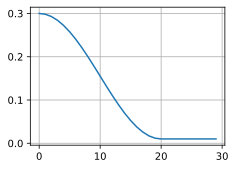

In [20]:
class CosineScheduler:
    def __init__(self, max_update, base_lr=0.01, final_lr=0,
                 warmup_steps=0, warmup_begin_lr=0):
        self.base_lr_orig = base_lr
        self.max_update = max_update
        self.final_lr = final_lr
        self.warmup_steps = warmup_steps
        self.warmup_begin_lr = warmup_begin_lr
        self.max_steps = self.max_update - self.warmup_steps

    def get_warmup_lr(self, epoch):
        increase = (self.base_lr_orig - self.warmup_begin_lr) \
                    * float(epoch) / float(self.warmup_steps)  # 直线增长
        return self.warmup_begin_lr + increase
    
    def __call__(self, epoch):
        if epoch < self.warmup_steps:
            return self.get_warmup_lr(epoch)
        if epoch <= self.max_update:
            self.base_lr = self.final_lr + (self.base_lr_orig - self.final_lr) * \
                (1 + math.cos(math.pi * (epoch - self.warmup_steps) / self.max_steps)) / 2
        return self.base_lr
    
scheduler = CosineScheduler(max_update=20, base_lr=0.3, final_lr=0.01)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

train loss 0.206, train acc 0.923, test acc 0.894


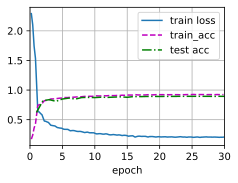

In [21]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.3)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device, scheduler)

### Pre-Heat

在某些情况下，初始化参数不足以得到良好的解。
这对某些高级网络设计来说尤其棘手，可能导致不稳定的优化结果。
对此，一方面，我们可以选择一个足够小的学习率，
从而防止一开始发散，然而这样进展太缓慢。
另一方面，较高的学习率最初就会导致发散。

解决这种困境的一个相当简单的解决方法是使用预热期，在此期间学习率将增加至初始最大值，然后冷却直到优化过程结束。
为了简单起见，通常使用线性递增。
这引出了如下表所示的时间表。

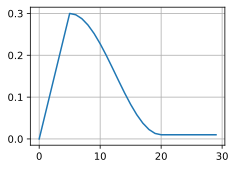

In [ ]:
scheduler = CosineScheduler(20, warmup_steps=5, base_lr=0.3, final_lr=0.01)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

train loss 0.174, train acc 0.936, test acc 0.900


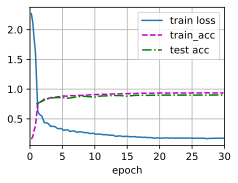

In [23]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.3)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler)

train loss 0.362, train acc 0.866, test acc 0.851


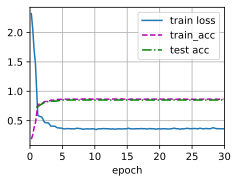

In [27]:
# 改变指数
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.3)
scheduler = lr_scheduler.PolynomialLR(trainer) 
train(net, train_iter, test_iter, num_epochs, loss, trainer, device, scheduler)